2018 Edition

# Building a music recommender system

As its name implies, a recommender system is a tool that helps predicting what a user may or may not like among a list of given items. In some sense, you can view this as an alternative to content search, as recommendation engines help users discover products or content that they may not come across otherwise. For example, Facebook suggests friends and pages to users. Youtube recommends videos which users may be interested in. Amazon suggests the products which users may need... Recommendation engines engage users to services, can be seen as a revenue optimization process, and in general help maintaining interest in a service.

In this notebook, we study how to build a simple recommender system: we focus on music recommendations, and we use a simple algorithm to predict which items users might like, that is called ALS, alternating least squares.

## Goals

In this lecture, we expect students to:

- Revisit (or learn) recommender algorithms

- Understand the idea of Matrix Factorization and the ALS algorithm (serial and parallel versions)

- Build a simple model for a real usecase: music recommender system

- Understand how to validate the results

## Steps

We assume students to work outside lab hours on the learning material. These are the steps by which we guide students, during labs, to build a good basis for the end-to-end development of a recommender system:

* Inspect the data using Spark SQL, and build some basic, but very valuable knowledge about the information we have at hand
* Formally define what is a sensible algorithm to achieve our goal: given the "history" of user taste for music, recommend new music to discover. Essentialy, we want to build a statistical model of user preferences such that we can use it to "predict" which additional music the user could like
* With our formal definition at hand, we will learn different ways to implement such an algorithm. Our goal here is to illustrate what are the difficulties to overcome when implementing a (parallel) algorithm
* Finally, we will focus on an existing implementation, available in the Apache Spark MLLib, which we will use out of the box to build a reliable statistical model

Now, you may think at this point we will be done!

Well, you'd better think twice: one important topic we will cover in all our Notebooks is **how to validate the results we obtain**, and **how to choose good parameters to train models** especially when using an "opaque" library for doing the job. As a consequence, we will focus on the statistical validation of our recommender system.


# 1. Data

Understanding data is one of the most important part when designing any machine learning algorithm. In this notebook, we will use a data set published by Audioscrobbler - a music recommendation system for last.fm. Audioscrobbler is also one of the first internet streaming radio sites, founded in 2002. It provided an open API for “scrobbling”, or recording listeners’ plays of artists’ songs. last.fm used this information to build a powerful music recommender engine.

## 1.1. Data schema

Unlike a rating dataset which contains information about users' preference for products (one star, 3 stars, and so on), the datasets from Audioscrobbler only has information about events: specifically, it keeps track of how many times a user played songs of a given artist and the names of artists. That means it carries less information than a rating: in the literature, this is called explicit vs. implicit ratings.

### Reading material

- [Implicit Feedback for Inferring User Preference: A Bibliography](http://people.csail.mit.edu/teevan/work/publications/papers/sigir-forum03.pdf)
- [Comparing explicit and implicit feedback techniques for web retrieval: TREC-10 interactive track report](http://trec.nist.gov/pubs/trec10/papers/glasgow.pdf)
- [Probabilistic Models for Data Combination in Recommender Systems](http://mlg.eng.cam.ac.uk/pub/pdf/WilGha08.pdf)

The data we use in this Notebook is available in 3 files (these files are stored in our HDFS layer, in the directory  ```/datasets/lastfm```):

- **`user_artist_data.txt`**: It contains about 140,000+ unique users, and 1.6 million unique artists. About 24.2 million users’ plays of artists’ are recorded, along with their count. It has 3 columns separated by spaces: 

| UserID | ArtistID | PlayCount |
|----|----|----|
| ...|...|...|


- **`artist_data.txt`** : It prodives the names of each artist by their IDs. It has 2 columns separated by tab characters (`\t`).

| ArtistID | Name |
|---|---|
|...|...|

- **`artist_alias.txt`**: Note that when plays are scrobbled, the client application submits the name of the artist being played. This name could be misspelled or nonstandard. For example, "The Smiths", "Smiths, The", and "the smiths" may appear as distinct artist IDs in the data set, even though they are plainly the same. `artist_alias.txt` maps artist IDs that are known misspellings or variants to the canonical ID of that artist. The data in this file has 2 columns separated by tab characters (`\t`).

| MisspelledArtistID | StandardArtistID |
|---|---|
|...|...|



## 1.2. Understanding data: simple descriptive statistic

In order to choose or design a suitable algorithm for achieving our goals, given the data we have, we should first understand data characteristics. To start, we import the necessary packages to work with regular expressions, Data Frames, and other nice features of our programming environment.

In [1]:
import os
import sys
import re
import random
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time

sqlContext = SQLContext(sc)
base = "/datasets/lastfm/"

### Question 1

#### Question 1.0 (Non-grading)
<div class="alert alert-info">
Using SPARK SQL, load data from `/datasets/lastfm/user_artist_data.txt` and show the first 20 entries (via function `show()`).
</div>

For this Notebook, from a programming point of view, we are given the schema for the data we use, which is as follows:

```
userID: long int
artistID: long int
playCount: int
```

Each line of the dataset contains the above three fields, separated by a "white space".

In [2]:
userArtistDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistID", LongType(), True), \
    StructField("playCount", IntegerType(), True)])

userArtistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=' ') \
    .load(base + "user_artist_data.txt", schema = userArtistDataSchema) \
    .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
userArtistDF.cache()

userArtistDF.show()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
|1000002| 1000013|        8|
|1000002| 1000014|       42|
|1000002| 1000017|       69|
|1000002| 1000024|      329|
|1000002| 1000025|        1|
|1000002| 1000028|       17|
|1000002| 1000031|       47|
|1000002| 1000033|       15|
|1000002| 1000042|        1|
|1000002| 1000045|        1|
|1000002| 1000054|        2|
|1000002| 1000055|       25|
|1000002| 1000056|        4|
|1000002| 1000059|        2|
|1000002| 1000062|       71|
+-------+--------+---------+
only showing top 20 rows



#### Question 1.1: 
<div class="alert alert-info">
How many distinct users do we have in our data? 
</div>

In [3]:
uniqueUsers = userArtistDF.select("userID").distinct().count()
print("Total n. of users: ", uniqueUsers)

Total n. of users:  148111


#### Question 1.2
<div class="alert alert-info">
How many distinct artists do we have in our data ?
</div>

In [4]:
uniqueArtists = userArtistDF.select("artistID").distinct().count()
print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1631028


#### Question 1.3
<div class="alert alert-info">
One limitation of Spark MLlib's ALS implementation - which we will use later - is that it requires IDs for users and items to be nonnegative 32-bit integers. This means that IDs larger than `Integer.MAX_VALUE`, or `2147483647`, can't be used. So we need to check whether this data set conforms to the strict requirements of our library.  

What are the maximum and minimum values of column `userID` ?  
</div>

In [5]:
userArtistDF.describe(['userID']).show()

+-------+------------------+
|summary|            userID|
+-------+------------------+
|  count|          24296858|
|   mean|1947573.2653533637|
| stddev| 496000.5551819132|
|    min|                90|
|    max|           2443548|
+-------+------------------+



**COMMENT**<br>
From the results obtained we can see that the maximum value is less than Integer.MAX_VALUE and the minimum value is greater than zero. This confirm what we were expecting. Moreover, we have also showed other interesting informations such as the mean, the total number or the std dev.

#### Question 1.4
<div class="alert alert-info">
What is the maximum and minimum values of column `artistID` ?
</div>

In [6]:
userArtistDF.describe(['artistID']).show()

+-------+------------------+
|summary|          artistID|
+-------+------------------+
|  count|          24296858|
|   mean|1718704.0937568964|
| stddev| 2539389.092428355|
|    min|                 1|
|    max|          10794401|
+-------+------------------+



**COMMENT**<br>
From the results obtained we can see that the maximum value is less than Integer.MAX_VALUE and the minimum value is greater than zero. This confirm what we were expecting.

We just discovered that we have a total of 148,111 users in our dataset. Similarly, we have a total of 1,631,028 artists in our dataset. The maximum values of `userID` and `artistID` are still smaller than the biggest number of integer type.  No additional transformation will be necessary to use these IDs.

One thing we can see here is that SPARK SQL provides very concise and powerful methods for data analytics (compared to using RDD and their low-level API). You can see more examples [here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html).

Next, we might want to understand better user activity and artist popularity.

Here is a list of simple descriptive queries that helps us reaching these purposes:

* How many times each user has played a song? This is a good indicator of who are the most active users of our service. Note that a very active user with many play counts does not necessarily mean that the user is also "curious"! Indeed, she could have played the same song several times.
* How many play counts for each artist? This is a good indicator of the artist popularity. Since we do not have time information associated to our data, we can only build a, e.g., top-10 ranking of the most popular artists in the dataset. Later in the notebook, we will learn that our dataset has a very "loose" definition about artists: very often artist IDs point to song titles as well. This means we have to be careful when establishing popular artists. Indeed, artists whose data is "well formed" will have the correct number of play counts associated to them. Instead, artists that appear mixed with song titles may see their play counts "diluted" across their songs.

### Question 2

#### Question 2.1
<div class="alert alert-info">
How many times each user has played a song? Show 5 samples of the result.
</div>

In [3]:
# Compute user activity
# We are interested in how many playcounts each user has scored.
userActivityDF = userArtistDF.groupBy("userID").agg(sum("playCount").alias("Total_playCounts"))
userActivityDF.show(5)
userActivity = userActivityDF.collect()

+-------+----------------+
| userID|Total_playCounts|
+-------+----------------+
|2289066|              51|
|2289173|            5938|
|2290086|            1080|
|2291343|              37|
|2291463|            8802|
+-------+----------------+
only showing top 5 rows



#### Question 2.2
<div class="alert alert-info">
Plot CDF (or ECDF) of the number of play counts per User ID.  

Explain and comment the figure you just created:   
<ul>
<li>for example, look at important percentiles (25%, median, 75%, tails such as >90%) and cross check with what you have found above to figure out if the result is plausible. </li>
<li>discuss about your users, with respect to the application domain we target in the notebook: you will notice that for some users, there is very little interaction with the system, which means that maybe reccommending something to them is going to be more difficult than for other users who interact more with the system. </li>
<li>look at outliers and reason about their impact on your reccommender algorithm</li>
</ul>
</div>

In [8]:
def annotate_percentiles(data, show_lines=True):
    percentiles = [0.25, 0.50, 0.75, 0.90]
    for y in percentiles:
        x = data[int(len(data)*y)]
        plt.annotate('%s' % x , xy=(x+0.2*x, y))
        if show_lines:
            plt.vlines(x, 0, y, linestyle="dashed")
            plt.hlines(y, 0, x, linestyle="dashed")
        plt.scatter(x, y, zorder=2, color="red")

In [9]:
def plot_ECDF(x, y, title, scale):
    plt.figure(figsize = (20, 8))
    plt.plot(x, y)
    plt.yticks(np.arange(1.1, step=0.1))
    plt.xlabel('Play Counts')
    plt.ylabel('ECDF')
    plt.grid(True, which="both", ls="-")
    plt.title(title)
    plt.xscale(scale)

In [10]:
def plot_box(x, title, scale):
    plt.figure(figsize = (15, 4))
    plt.boxplot(x, vert=False, patch_artist=True)
    plt.title(title)
    plt.grid(True, which="both", ls="-")
    plt.xscale(scale)

[     0      1      2 ... 148108 148109 148110]


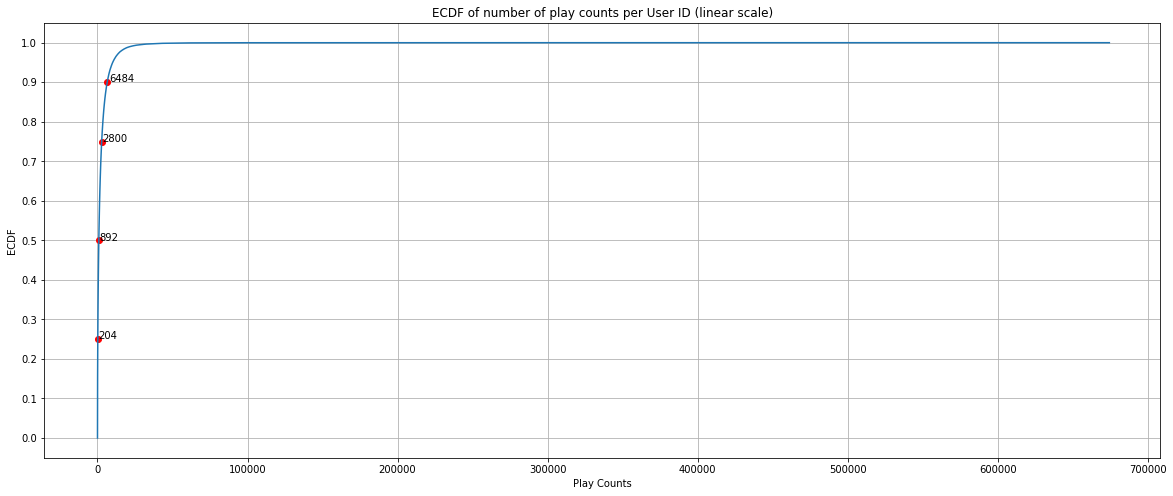

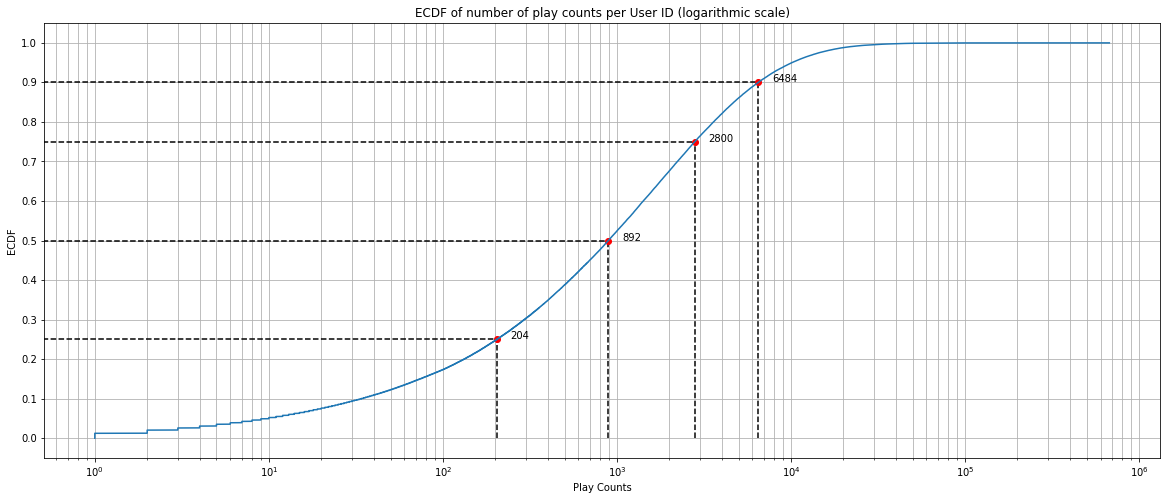

In [11]:
pdf = pd.DataFrame(data=userActivity)
Y = np.sort( pdf[1] )
yvals = np.arange(len(Y))/float(len(Y))

print(np.arange(len(Y)))

#Plot with linear scale
plot_ECDF(Y, yvals, 'ECDF of number of play counts per User ID (linear scale)', "linear")
annotate_percentiles(Y, False)
plt.show()

#Plot with logarithmic scale
plot_ECDF(Y, yvals, 'ECDF of number of play counts per User ID (logarithmic scale)', "log")

#Annotate important percentiles
annotate_percentiles(Y)
plt.show()

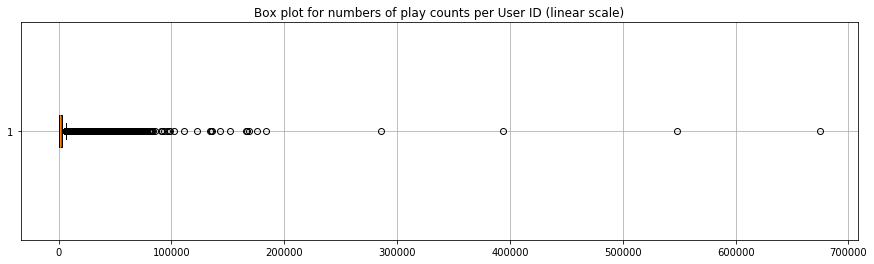

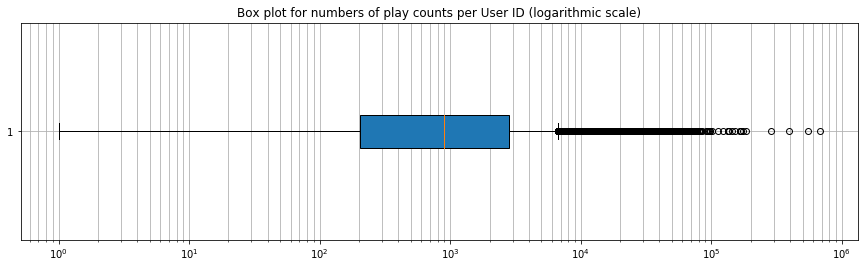

In [12]:
plot_box(Y, 'Box plot for numbers of play counts per User ID (linear scale)', "linear")
plot_box(Y, 'Box plot for numbers of play counts per User ID (logarithmic scale)', "log")

**COMMENT**<br>
In this case we decided to implement two different plots: a simple ECDF line plot and a box plot.

In the first case we have represented the ECDF of the number of play counts per user ID: on the x axis there is the "play count", which is the number of played songs, while on the y axis there is the cumulative percentage, which gives the portion of users.<br>
We decided to use a logarithmic and a linear scale to better visualize the entire plot, because with the linear one is possible to better visualize the outliers (all values after the initial spike towards the 100% percentile), whereas with the logarithmic one is possible to better visualize the values of Play Counts for each percentile.<br>
Then we annotated the number of users in correspondance of the most important percentiles (25%, 50%, 75%, 90%).
It is possible to see, for example, that the 25% of the users have less than 204 played songs, or that the 75% of them have less than 2800 songs, and so on.

In the second diagram, instead, we wanted to model the same concept with a different representation. The box plot diagram, in fact, helps in defining the upper limit and lower limit beyond which any data lying will be considered as outliers. The very purpose of this diagram is to identify outliers before making any further observation so that the conclusion made from the study gives more accurate results not influenced by any extremes or abnormal values.<br>
In this case it's easier to see how the box plot marks the lower quartile, the upper quartile, and the lower and upper limits. So any value that will be more than the upper limit or lesser than the lower limit could be an outlier. Only the data that lies within lower and upper limit are statistically considered normal. As per the basic standards followed by all statistics a convenient definition of an outlier is a point which falls more than 1.5 times the interquartile range above the third quartile or below the first quartile.<br>
Also in this case we decided to represent the box plot with two different scales: linear and logarithmic; this because with the linear scale the outliers are more evident (points which are far from the "core" ones).

From the plots above we can infer that some of the highest values in the dataset can be outliers (in the box plot, we may consider the four values which are "alone" at the right as outliers); those are counterproductive for a recommendation system as they could polarize the predictions due to the high volume of played songs with respect to the other users. We don't know how many years are covered by the analyzed dataset, but having a playcount bigger than 10^6 is impossibile for whatever user.<br>
Another problem can be related to the users who have a very low interaction with the system (below the first quartile), for those users it is not possible to easily recommend something since we don't have much information about them, so initial recommendations may not really reflect their real preferences but the algorithm will get better as they become more active.

Regarding the values we extracted above (Total_playCounts), we can verify that just a few users played more than 10^5, which is in line with the previous results.

Now let's see how these plots would look like by eliminating the outliers. As discussed, we want to eliminate all the points after the initial spike toward the 100%, so in this case we have decided to eliminate all the users that have more than 2x10^4 total play counts.

In [31]:
users_outliers = userActivityDF.filter('Total_playCounts > 20000').select('userID')
print("Number of outliers found:", users_outliers.count())
userArtistDFWithoutOutliers = userArtistDF.filter(userArtistDF.userID.isin([x[0] for x in users_outliers.collect()]) == False)
userArtistDFWithoutOutliers = userArtistDFWithoutOutliers.cache()

Number of outliers found: 1769


**NB:** Here we have produced a new dataframe without outliers. From now on, we will keep both the versions (with and without outliers) of the dataframes, trying to evaluate the differences and their impact on the system. Both those datasets will be useful later on, when running the recommendation system, to eventually analyze the differences.

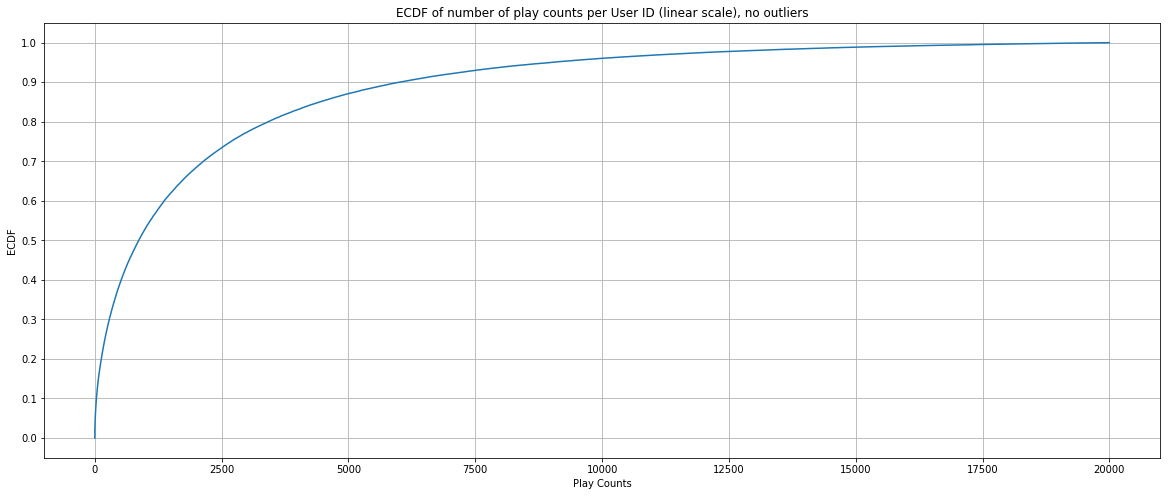

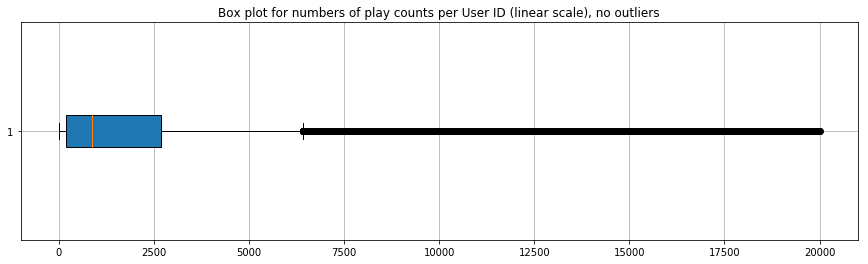

In [14]:
pdf = pd.DataFrame(data=userActivityDF.filter('Total_playCounts <= 20000').collect())
Y = np.sort( pdf[1] )
yvals = np.arange(len(Y))/float(len(Y))
plot_ECDF(Y, yvals, 'ECDF of number of play counts per User ID (linear scale), no outliers', "linear")
plot_box(Y, 'Box plot for numbers of play counts per User ID (linear scale), no outliers', "linear")

Here we have re-proposed the two plots (ECDF and box) with linear scale. Here it's immediately possible to show the positive effect of the elimination of the outliers as the the ECDF has a smooter trend without any direct spike and in the (linear) box plot the "box" is now visible. However, the box plot still suggests to eliminate other users.

#### Question 2.3

<div class="alert alert-info">
How many play counts for each artist? Plot CDF or ECDF of the result.  

Similarly to the previous question, you need to comment and interpret your result: what is the figure telling you?
</div>

In [15]:
# Compute artist popularity
# We are interested in how many playcounts per artist
# ATTENTION! Grouping by artistID may be problematic, as stated above.

artistPopularity = userArtistDFWithoutOutliers.groupBy("artistID").agg(sum("playCount").alias("Total_playCounts"))
artistPopularity.show(5)
artistPopularity = artistPopularity.collect()

+--------+----------------+
|artistID|Total_playCounts|
+--------+----------------+
| 1000313|          111718|
| 1233634|           13356|
|    5409|          417396|
| 1001530|          163391|
| 1007205|           40990|
+--------+----------------+
only showing top 5 rows



**COMMENT**<br>
In this case grouping by artistID could be problematic because there is the problem of mispelled IDs that can falsify the results of our analysis. This problem will be solved later on, so for now we are proposing this as a first result of our analysis, but we are aware that this is partially incorrect.

[      0       1       2 ... 1557102 1557103 1557104]


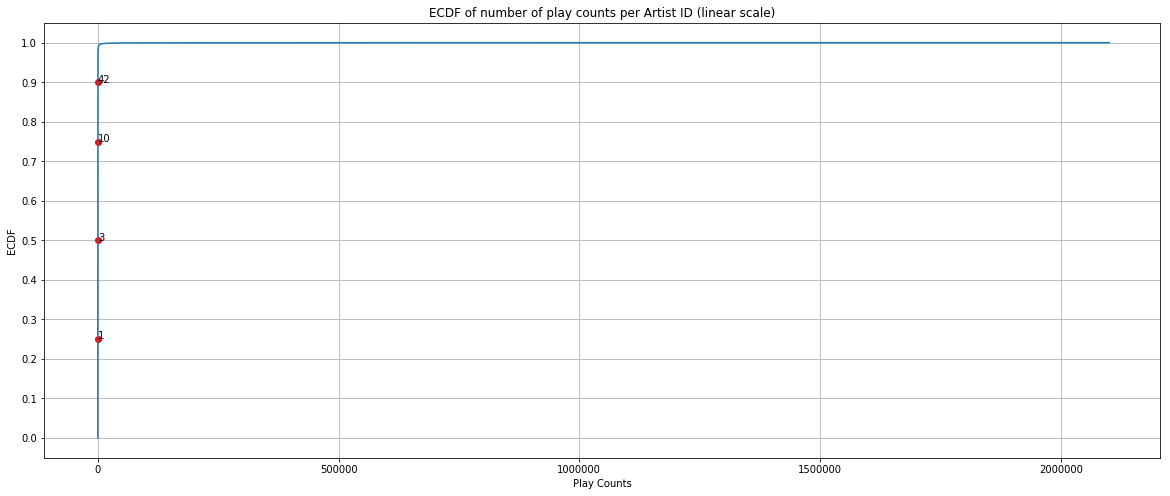

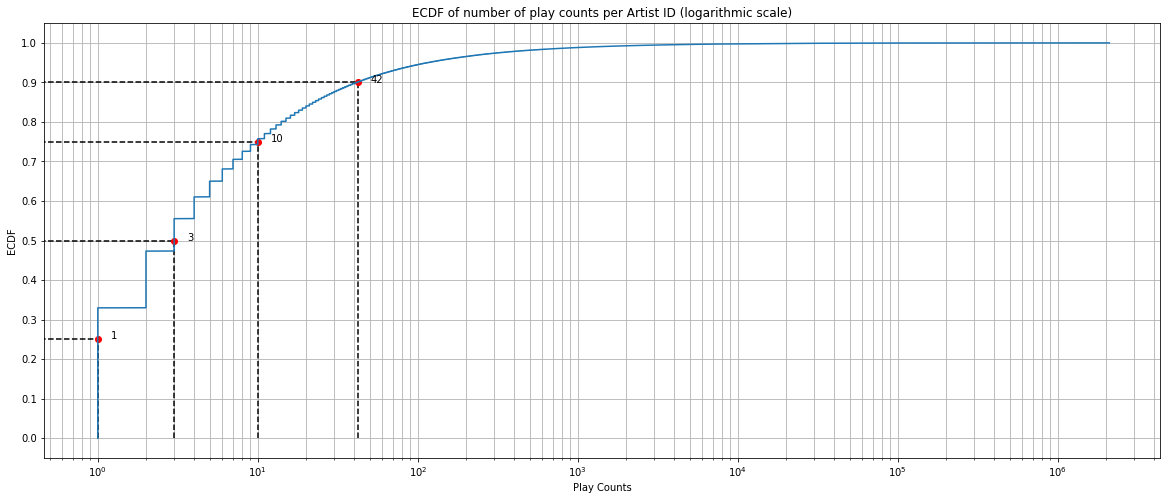

In [16]:
pdf = pd.DataFrame(data=artistPopularity)

Y = np.sort( pdf[1] )
yvals = np.arange(len(Y))/float(len(Y))

print(np.arange(len(Y)))

#Plot with linear scale
plot_ECDF(Y, yvals, 'ECDF of number of play counts per Artist ID (linear scale)', "linear")
annotate_percentiles(Y, False)
plt.show()

#Plot with logarithmic scale
plot_ECDF(Y, yvals, 'ECDF of number of play counts per Artist ID (logarithmic scale)', "log")

#Annotate important percentiles
annotate_percentiles(Y)
plt.show()

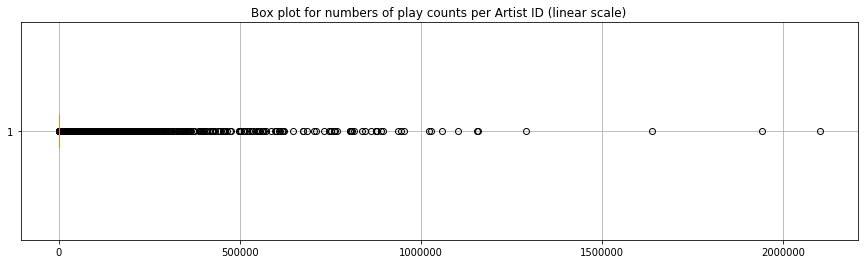

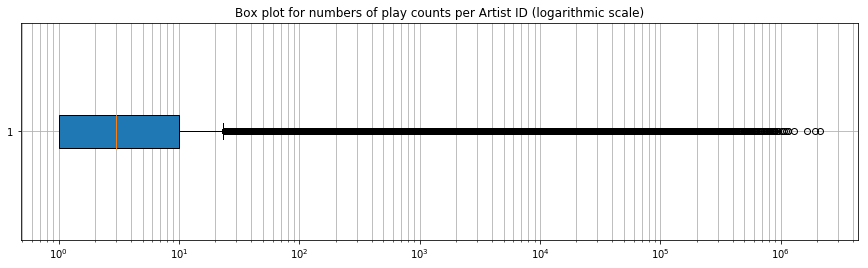

In [17]:
plot_box(Y, 'Box plot for numbers of play counts per Artist ID (linear scale)', "linear")
plot_box(Y, 'Box plot for numbers of play counts per Artist ID (logarithmic scale)', "log")

**COMMENT**<br>
As before, also in this case we have used the two representations: line ECDF and box plots.

In the first plot we have represented the ECDF of number of play counts per Artist ID: x axis for the play counts and y for the cumulative percentage; also in this case, in addition to the linear representation, we decided to use a logarithmic scale to better visualize the entire plot, and we have annotated the number of artists in correspondance of the most important percentiles.<br>
In this case we can see, for example, that less popular artists have a very low number of played songs, in particular about the half of artists have been listened to less than 3 times. While there are some of them, which have a huge number of played songs, probably because of their popularity: most popular artists tends to be played by everyone.

And again, in the second plot we have modeled the data using two box diagrams.

In this case, however, we decided to not eliminate any "outlier" because it's possible that we have artists that are more famous and known than others, and we think that we should not prevent the recommendation system to suggest those kind of very popular artists. However, at the contrary, there is the problem of the smallest artists, which will be hardly suggested due to their very low audience size.

#### Question 2.4
<div class="alert alert-info">
Plot a bar chart to show top 5 artists In terms of absolute play counts.  

Comment the figure you just obtained: 
<ul>
<li>are these reasonable results?</li>
<li>is looking at top-5 artists enough to learn more about your data?</li>
<li>do you see anything strange in the data?</li>
</ul>
</div>

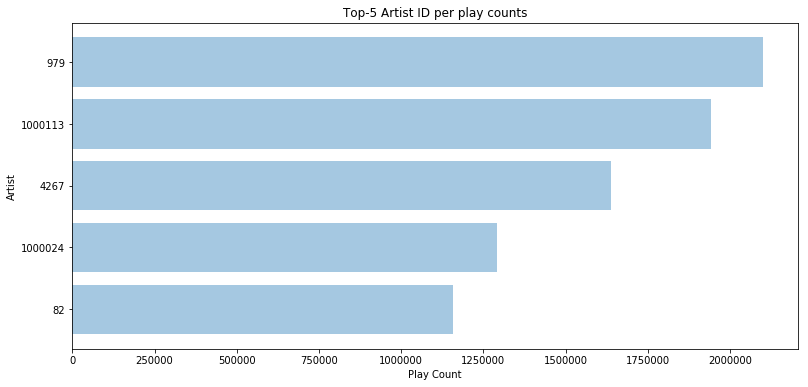

In [18]:
sortedArtist = sorted(artistPopularity, key = lambda x: -x[1])[:5]

artistID = [w[0] for w in sortedArtist]

y_pos = range(len(sortedArtist))
frequency = [w[1] for w in sortedArtist]

plt.figure(figsize=(13,6))
plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos, artistID[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-5 Artist ID per play counts')
plt.show()

**COMMENT**<br>
Apparently these results are reasonable according to what we obtained in the previous plot of question 2.3 as the biggest and most popular artists have a playcount of 10^6.

Looking at top-5 artists only is not enough to learn more about our data. Instead it could be more useful to look at a distribution like the one of question 2.3 to have a global view of the play counts for all the artists. Moreover, we might be interested in analyzing the names of those artists, to discover eventual errors (multiple ids referring to the same artist, 'unknown' artists or mispelled names...). If we 

If we consider only the data we have obtained until now we do not see anything strange at this point...but we will soon get deeper in the details.

All seems clear right now, but ... wait a second! What about the problems indicated above about artist "disambiguation"? Are these artist ID we are using referring to unique artists? How can we make sure that such "opaque" identifiers point to different bands? Let's try to use some additional dataset to answer this question:  `artist_data.txt` dataset. This time, the schema of the dataset consists in:

```
artist ID: long int
name: string
```

We will try to find whether a single artist has two different IDs.

### Question 3

#### Question 3.1

<div class="alert alert-info">
Load the data from `/datasets/lastfm/artist_data.txt` and use the SparkSQL API to show 5 samples.  

<ul></ul>
<div class="label label-success">HINT:</div> If you encounter some error when parsing lines in data because of invalid entries, parameter `mode='DROPMALFORMED'` will help you to eliminate these entries. The suggested syntax is: `<df>.options(header='false', delimiter='\t', mode='DROPMALFORMED')`.

</div>

In [4]:
customSchemaArtist = StructType([ \
    StructField("artistID", LongType(), True), \
    StructField("name", StringType(), True)])

artistDF = sqlContext.read \
        .format('com.databricks.spark.csv') \
        .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
        .load(base + "artist_data.txt", schema = customSchemaArtist) \
        .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
artistDF.cache()
    
artistDF.show(5, truncate=False)

+--------+----------------------------+
|artistID|name                        |
+--------+----------------------------+
|1134999 |06Crazy Life                |
|6821360 |Pang Nakarin                |
|10113088|Terfel, Bartoli- Mozart: Don|
|10151459|The Flaming Sidebur         |
|6826647 |Bodenstandig 3000           |
+--------+----------------------------+
only showing top 5 rows



#### Question 3.2
<div class="alert alert-info">
Find 20 artists whose name contains `Aerosmith`. Take a look at artists that have ID equal to `1000010` and `2082323`. In your opinion, are they pointing to the same artist?  

<ul></ul>
<div class="label label-success">HINT:</div> Function `locate(sub_string, string)` can be useful in this case.
</div>

In [20]:
# get artists whose name contains "Aerosmith"
artistDF[locate("Aerosmith", artistDF.name) > 0].show(truncate=False)

# show two examples
artistDF[artistDF.artistID==1000010].show()
artistDF[artistDF.artistID==2082323].show()

+--------+----------------------------------------------+
|artistID|name                                          |
+--------+----------------------------------------------+
|10586006|Dusty Springfield/Aerosmith                   |
|6946007 |Aerosmith/RunDMC                              |
|10475683|Aerosmith: Just Push Play                     |
|1083031 |Aerosmith/ G n R                              |
|6872848 |Britney, Nsync, Nelly, Aerosmith,Mary J Blige.|
|10586963|Green Day - Oasis - Eminem - Aerosmith        |
|10028830|The Aerosmith Antology2                       |
|10300357|Run-DMC + Aerosmith                           |
|2027746 |Aerosmith by MusicInter.com                   |
|1140418 |[rap]Run DMC and Aerosmith                    |
|10237208|Aerosmith + Run DMC                           |
|10588537|Aerosmith, Kid Rock, & Run DMC                |
|9934757 |Aerosmith - Big Ones                          |
|10437510|Green Day ft. Oasis & Aerosmith               |
|6936680 |RUN 

**COMMENT**<br>
From the results we have obtained we can conclude that the artists that have ID equal to 1000010 and 2082323 refer to the same one: Aerosmith. We can say that by looking at the two names "Aerosmith" and "01 Aerosmith". In the second case there is only '01' at the beginning of the name, but it surely refers to the same artist.<br>
The same thing can be said also for other cases in the list shown above. In fact, despite of the fact that most of the names refer to more than one single artist, we can see also cases in which, as it happened for the two ids above, there is only a mispelling case (eg. 'Aerosmith?').<br>
But which one is the correct one? How can we solve all the problems?

To answer this question correctly, we need to use an additional dataset `artist_alias.txt` which contains the ids of mispelled artists and standard artists. The schema of the dataset consists in:

```
mispelledID ID: long int
standard ID: long int
```

#### Question 3.3
<div class="alert alert-info">
Using SparkSQL API, load the dataset from `/datasets/lastfm/artist_alias.txt` then show 5 samples.
</div>

In [5]:
customSchemaArtistAlias = StructType([ \
    StructField("mispelledID", LongType(), True), \
    StructField("standard", LongType(), True)])

artistAliasDF = sqlContext.read \
        .format('com.databricks.spark.csv') \
        .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
        .load(base + "artist_alias.txt", schema = customSchemaArtistAlias) \
        .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
artistAliasDF.cache()
    
artistAliasDF.show(5, truncate=False)

+-----------+--------+
|mispelledID|standard|
+-----------+--------+
|1092764    |1000311 |
|1095122    |1000557 |
|6708070    |1007267 |
|10088054   |1042317 |
|1195917    |1042317 |
+-----------+--------+
only showing top 5 rows



#### Question 3.4
<div class="alert alert-info">
Verify the answer of question 3.2 ("Are artists that have ID equal to `1000010` and `2082323` the same ?") by finding the standard ids corresponding to the mispelled ids `1000010` and `2082323` respectively.
</div>

In [22]:
artistAliasDF[artistAliasDF.standard == 1000010].show()
artistAliasDF[artistAliasDF.mispelledID == 2082323].show()

# 1000010 is a standard id, so it haven't been considered as mispelled id in the dataset
artistAliasDF[artistAliasDF.mispelledID == 1000010].show()

+-----------+--------+
|mispelledID|standard|
+-----------+--------+
|    2082323| 1000010|
|    1019565| 1000010|
|    1053793| 1000010|
|    1128909| 1000010|
|    1174667| 1000010|
|    9899575| 1000010|
|    1104722| 1000010|
|    6796858| 1000010|
|    6784259| 1000010|
|    1227381| 1000010|
|    2027746| 1000010|
|    6845323| 1000010|
|    1059795| 1000010|
|    6617824| 1000010|
|    2015907| 1000010|
|    6630890| 1000010|
|    2046837| 1000010|
|    2048373| 1000010|
|    2070290| 1000010|
|    2035537| 1000010|
+-----------+--------+
only showing top 20 rows

+-----------+--------+
|mispelledID|standard|
+-----------+--------+
|    2082323| 1000010|
+-----------+--------+

+-----------+--------+
|mispelledID|standard|
+-----------+--------+
+-----------+--------+



**COMMENT**<br>
From the results obtained above we can confirm what we have said before about the mispelled artists: 2082323 refers to the same artist of 1000010. Moreover, as we expected, there are a lot of other mispelled ids that refer to the artist Aerosmith. From those informations we have discovered that the id 1000010 is the standard one, as it always appear in the "standard" column, and if we try to filter the mispelled ids with this user we get an empty table.<br>
So what we have to do now is "clean" those data, removing all the wrong mappings and aggregate all the results.

### Question 4

The mispelled or nonstandard information about artist make our results in the previous queries a bit "sloppy". To overcome this problem, we can replace all mispelled artist ids by the corresponding standard ids and re-compute the basic descriptive statistics on the "amended" data.
First, we construct a "dictionary" that maps non-standard ids to a standard ones. Then this "dictionary" will be used to replace the mispelled artists.

#### Question 4.1
<div class="alert alert-info">
From data in the dataframe loaded from `/datasets/lastfm/artist_alias.txt`, construct a dictionary that maps each non-standard id to its standard id.  

<div class="label label-success">HINT:</div> Instead of using function `collect`, we can use `collectAsMap` to convert the collected data to a dictionary inline.
</div>

In [6]:
artistAlias = artistAliasDF.rdd.map(lambda row: (row[0], row[1])).collectAsMap()

#### Question 4.2
<div class="alert alert-info">
Using the constructed dictionary in question 4.1, replace the non-standard artist ids in the dataframe that was loaded from `/datasets/lastfm/user_artist_data.txt` by the corresponding standard ids then show 5 samples.
</div>


**NOTE 1**: If an id doesn't exist in the dictionary as a mispelled id, it is really a standard id.


Using funtion `map` on Spark Dataframe will give us an RDD. We can convert this RDD back to Dataframe by using `sqlContext.createDataFrame(rdd_name, sql_schema)`


**NOTE 2**: be careful! you need to be able to verify that you indeed solved the problem of having bad artist IDs. In principle, for the new data to be correct, we should to have duplicate pairs (user, artist), potentially with different play counts, right? In answering the question, please **show** that you indeed fixed the problem. 

In [7]:
from time import time

def replaceMispelledIDs(fields):
    finalID = artistAlias.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)
newUserArtistDF.show(5)

t1 = time()

print('The script takes %f seconds' %(t1-t0))

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 0.987097 seconds


### Analysis on artist-alias dataframe

The first thing we want to check at this point is the eventual presence of errors in the artist-alias table.<br>

In [25]:
(artistAliasDF.select('standard')).intersect(artistAliasDF.select('mispelledID')).show()

+--------+
|standard|
+--------+
| 1008798|
| 1053468|
| 1042639|
| 1003219|
| 1013851|
| 1164008|
|    2684|
| 6817660|
| 1167860|
|10151717|
| 1252142|
| 1199012|
| 1043468|
| 1240778|
| 6995268|
| 6603878|
| 1004143|
|     754|
| 2137055|
| 1044091|
+--------+
only showing top 20 rows



By doing the intersection between mispelled ids and standard ids (the two columns of the alias table), we demonstrate that there are chains in the mispelled->artist mapping; this means that the first "cleaning" phase does not effectively perfectly clean the dataset because some artists may have been remapped to a mispelled id (= standard id).<br>
Let's check for others errors...

In [11]:
mispelledEquals = artistAliasDF.filter(artistAliasDF.standard == artistAliasDF.mispelledID)
mispelledEquals.show()

+-----------+--------+
|mispelledID|standard|
+-----------+--------+
|    1018110| 1018110|
|    1014609| 1014609|
|    1014175| 1014175|
|    1008798| 1008798|
|    1013851| 1013851|
|    1001864| 1001864|
|         15|      15|
|    1167860| 1167860|
|        754|     754|
|    1006322| 1006322|
|    1006347| 1006347|
+-----------+--------+



There are even cases (11) in which a mispelledID is equal to a standard one! This can be easily seen in the table above, where we have filtered the alias dataframe by looking for such cases.

Because of this, the cleaning phase we performed above may have not been effective; the dataframe is not cleaned yet, and in order to prove that we can procede as follow:

In [27]:
newUserArtistDF.join(artistAliasDF, [newUserArtistDF.artistID == artistAliasDF.mispelledID]).show()

+-------+--------+---------+-----------+--------+
| userID|artistID|playCount|mispelledID|standard|
+-------+--------+---------+-----------+--------+
|1000020|      15|        9|         15|      15|
|1000020| 1001864|        2|    1001864| 1001864|
|1000020| 1006322|        4|    1006322| 1006322|
|1000020|      15|        8|         15|      15|
|1000020|     754|      209|        754|     754|
|1000033| 1014609|        1|    1014609| 1014609|
|1000033|      15|       23|         15|      15|
|1000036|     754|        1|        754|     754|
|1000037| 1001864|       12|    1001864| 1001864|
|1000037|      15|        1|         15|      15|
|1000037|     754|        5|        754|     754|
|1000047| 1001864|        8|    1001864| 1001864|
|1000049| 1014609|        1|    1014609| 1014609|
|1000054|      15|       22|         15|      15|
|1000056|      15|        1|         15|      15|
|1000071| 1014609|       27|    1014609| 1014609|
|1000087|      15|        1|         15|      15|


We joined the new dataframe with the alias one on the artistID (artistID of the new df with mispelled ids of the alias df) expecting, in case of a complete cleaning, an empty table, as no mispelled tuple would have been present in the new dataframe in that case. However, as expected, the output table is not empty: as said, this happens because there are chains among the artist ids and the mispelled ids in the alias dataframe.<br>
Now we want to correct those chains.<br>
NB: In this case we joined the tables instead of simply intersecting the columns because we wanted to show also the various ids of the two tables.

In [8]:
# removes the tuples where mispelled == standard from the alias map
def removeMirrors(alias):
    toremove = [k for k in alias if k == alias[k]]
    for k in toremove:
        del alias[k]
    return len(toremove)

# removes the chains from the alias map
def cleanAliasMap(alias):
    count = 0
    for mispelled, standard in alias.items():
        tocheck = alias.get(standard)
        while(tocheck != None):
            count += 1
            alias[mispelled] = tocheck
            tocheck = alias.get(tocheck)
    return count

In [9]:
print("Removed", removeMirrors(artistAlias), "mirrored ids")
print("Removed", cleanAliasMap(artistAlias), "chained ids")

Removed 11 mirrored ids
Removed 55 chained ids


We implemented those two functions to remove the "mirrors" cases in the map (mispelled == standard id) and to remove the chains (mispelled -> standard = mispelled). Now we have a good, cleaned map we can work with for the real and complete cleaning phase.

### Cleaning

Initially we were thinking to loop the dataframe creation procedure (in order to remove the chains) until the dataset was not completely cleaned. However, cleaning directly the map is a much more efficient way of doing this; moreover it will be also useful later on (when working on the rdds) as we won't have to reapply the cleaning procedure again and again, but only one call will be enough.

In this section it's possibile to find three "paragraphs" P1, P2 and P3, and an explanatory comment at the and.<br>
The output of the section will be a completely cleaned dataframe.

As we have fixed all the problems related to the alias map, now we can apply the cleaning procedure and obtain the desired status. We just need to recreate the dataframe as we did above and remove all the "mirrored" tuples from it.

In [10]:
# just use the alias map to clean the dataframe (the map is supposed to be already cleaned)
# than left anti join with mispelled artists to remove the "mirrors"
def cleanData(df):
    newUserArtistDF = sqlContext.createDataFrame(
        df.rdd.map(replaceMispelledIDs), 
        userArtistDataSchema
    )
    
    return newUserArtistDF.join(mispelledEquals, [newUserArtistDF.artistID == mispelledEquals.mispelledID], "leftanti")

In [12]:
newUserArtistDF = cleanData(userArtistDF)
newUserArtistDF = newUserArtistDF.cache()

**P1**

In [32]:
newUserArtistDF.join(artistDF, ['artistID'])[locate("Aerosmith", artistDF.name) > 0].show(truncate=False)
newUserArtistDF[newUserArtistDF.artistID == 2082323].show()

+--------+-------+---------+-----------------------------------------+
|artistID|userID |playCount|name                                     |
+--------+-------+---------+-----------------------------------------+
|10781496|2134459|1        |RUN-D.M.C. F/ Aerosmith                  |
|10615674|2386789|3        |Green Day vs Oasis vs Travis vs Aerosmith|
|10615674|2038676|6        |Green Day vs Oasis vs Travis vs Aerosmith|
|10503361|2291809|2        |Green Day vs Oasis vs Aerosmith vs Eminem|
|10545537|1003317|1        |Run-D.M.C. / Aerosmith                   |
|10545537|2323988|1        |Run-D.M.C. / Aerosmith                   |
|10391317|2274287|1        |087 - Aerosmith & Run-D.M.C              |
|10568609|2329079|1        |STP / Aerosmith                          |
|10568609|2415880|1        |STP / Aerosmith                          |
|7023100 |2183636|1        |Aerosmith & Guns N Roses                 |
|7023100 |2073349|1        |Aerosmith & Guns N Roses                 |
|10586

**P2**

In [33]:
def checkDuplicatedPairs(df):
    df.groupBy("userID", "artistID").count().orderBy("count", ascending=False).show()

In [34]:
checkDuplicatedPairs(newUserArtistDF)

+-------+--------+-----+
| userID|artistID|count|
+-------+--------+-----+
|2052189| 1082784|   71|
|2360120|     122|   68|
|2302495| 1000024|   65|
|1053375| 1001819|   57|
|2214793| 1000130|   54|
|2181817|      82|   48|
|1000072| 1021625|   46|
|2197708| 1005386|   43|
|2117500| 1000881|   41|
|2054029| 1001419|   41|
|2360120|    1190|   40|
|2017825| 1003694|   38|
|2140727| 1026675|   33|
|2054029|    2439|   33|
|2197701| 1002646|   33|
|2205461|10316280|   32|
|2205665| 1116582|   32|
|1053335| 1000597|   32|
|2214793|    4481|   32|
|2159933| 1234421|   30|
+-------+--------+-----+
only showing top 20 rows



**P3**

In [35]:
newUserArtistDF.join(artistAliasDF, [newUserArtistDF.artistID == artistAliasDF.mispelledID]).show()

+------+--------+---------+-----------+--------+
|userID|artistID|playCount|mispelledID|standard|
+------+--------+---------+-----------+--------+
+------+--------+---------+-----------+--------+



**COMMENT**<br>
After having substituted the mispelled artistIds with their standard ones, we have demonstrated the correctness of this modification by using different approaches:

**P1:** first of all we have repeated the same query as in the paragraph 3 about the 'Aerosmith' artist, which appeared to be a mispelled one, just to check that that problem was solved; the first 20 rows of the table don't show anything strange in the names and the query on the mispelled attribute now returns an empty table.

**P2:** then we showed that in the new produced dataframe there are now "duplicated tuples" (user-artist) because of the substitutions of the mispelled ones: in fact, a mispelled id is a wrong id which is related to a well defined one (standard id), and multiple mispelled ids are mapped towards the same standard id; so every time we "solve the chain", we are creating a new tuple user-artist which probably already exists in the dataset. Obviously this is still a problem that will be resolved further on.

**P3:** then, to effectively prove that no mispelled attributes are anymore in the dataset, we repeated the same join as showed above between the new dataframe and the alias one. In this case, as expected, we have obtained an empty table because now no mispelled tuple is present in the new dataframe.

To finish with the cleaning phase, we just have to fix up what we showed in P2: after having finished with the mispelled ids replacement, the dataframe contains a lot of "duplicated" user/artists pairs with different playcounts, so we need to aggregate all those pairs by summing all the play count and producing only one tuple.

In [13]:
newUserArtistDF = newUserArtistDF.groupBy("userID", "artistID").agg(sum("playCount").alias("playCount"))
newUserArtistDF = newUserArtistDF.cache()

In [37]:
checkDuplicatedPairs(newUserArtistDF)

+-------+--------+-----+
| userID|artistID|count|
+-------+--------+-----+
|2013266| 1013516|    1|
|2013266|10254255|    1|
|2013279| 2146039|    1|
|2013285| 1010316|    1|
|2013296| 1000024|    1|
|2013305| 1000265|    1|
|2013306| 2088997|    1|
|2013310| 1000591|    1|
|2013310| 1001002|    1|
|2013316| 1007075|    1|
|2013322| 1006229|    1|
|2013322| 1086193|    1|
|2013322| 1123168|    1|
|2013322| 1151575|    1|
|2013327|10513108|    1|
|2013328| 1002676|    1|
|2013328| 1004932|    1|
|2013328| 1016309|    1|
|2013328| 1024832|    1|
|2013328| 1230676|    1|
+-------+--------+-----+
only showing top 20 rows



From the tables above it's possibile to check that we have solved also this problem: we have shown in P2 the table with the duplicated pairs, and now we show the same table, by using the same function, after having removed all the duplicates. In this case all the counts are equal to 1 (note: the table is ordered by decreasing count).

In [32]:
# just summarize all in one function: clean and aggregate
def cleanDataAndAggregate(df):
    cleanedDF = cleanData(df)
    return cleanedDF.groupBy("userID", "artistID").agg(sum("playCount").alias("playCount"))

#### Question 4.3
<div class="alert alert-info">
Spark actions are executed through a set of stages, separated by distributed "shuffle" operations. Spark can be instructed to **automatically and efficiently** broadcast common data needed by tasks within **each stage**. The data broadcasted this way is cached in **serialized form** and deserialized before running each task.   
<ul> </ul>
We can thus improve our answer to question 4.2: we can reduce the communication cost by shipping the "dictionary" in a more efficient way by using `broadcast variable`. Broadcast variables allow the programmer to keep a read-only variable cached on **each machine** rather than shipping a copy of it with tasks. They are cached in deserialized form. They can be used, for example, to give every node a copy of a large input dataset in an efficient manner.   
<ul></ul>
The broadcast of variable `v` can be created by `bV = sc.broadcast(v)`. Then value of this broadcast variable can be access via `bV.value`  

<ul></ul>
To question is then: using a broadcast variable, modify the script in question 4.2 to get better performance in terms of running time.
</div>


In [39]:
from time import time

bArtistAlias = sc.broadcast(artistAlias)

def replaceMispelledIDs(fields):
    finalID = bArtistAlias.value.get(fields[1] , fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)
newUserArtistDF.show(5)
t1 = time()

print('The script takes %f seconds' %(t1-t0))

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 0.243885 seconds


**COMMENT**<br>
The main advantage of using broadcast variables is that a copy of the artist-alias map is sent to all the workers: in this way we skip the serialization/deserialization step that otherwise would have been required at each task, and the map is broadcasted only once to each worker.

Let's finalize the cleaning to both the normal and the "outliers-free" dataframe.

In [33]:
# creating a new cleaned dataframe also for the case without outliers
newUserArtistDFwithoutOutliers = cleanDataAndAggregate(userArtistDFWithoutOutliers)
newUserArtistDFwithoutOutliers = newUserArtistDFwithoutOutliers.cache()

In [41]:
# creating a new cleaned dataframe also for the case without outliers
newUserArtistDF = cleanDataAndAggregate(userArtistDF)
newUserArtistDF = newUserArtistDF.cache()

Although having some advantages, explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

### Question 5

Well, our data frame contains clean and "standard" data. We can use it to redo previous statistic queries.

#### Question 5.1
<div class="alert alert-info">
How many unique artists? Compare with the result when using old data.
</div>

In [42]:
uniqueArtists = newUserArtistDF.select("artistID").distinct().count()

print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1568106


**COMMENT**<br>
Here we can see that the number of artists after the cleaning phase is decresed with respect to the count above, this demonstrates the effectiveness of this step.

In [43]:
uniqueArtists = newUserArtistDFwithoutOutliers.select("artistID").distinct().count()

print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1497452


**COMMENT**<br>
One thing we may want to notice is the number of different artists in the "outliers-free dataset". Here, despite the fact we wanted to remove only users, we have also cut off a lot of small artists.

#### Question 5.2

<div class="alert alert-info">
Who are the top-10 artistis?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "audience size", that is, how many users listened to one of their track at least once</li>
</ul>  

Plot the results, and explain the figures you obtain.
</div>

In [44]:
# just plot the top 10 elements in the given dataset
def plot_top10(dataset, title, xlabel, ylabel):
    y_pos = range(len(dataset))
    pdf = pd.DataFrame(data=dataset)

    plt.figure(figsize=(15,6))
    plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
    plt.yticks(y_pos, pdf[0][::-1])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [45]:
# rearrange data to plot top 10 artists per play count
def top_10_artists_per_playCount(df, title):
    # calculate top-10 artists in term of play counts
    topArtistsAbs = df.groupBy('artistID').agg(sum('playCount').alias('totPlayCount'))
    # this join is done with the purpose of printing the names of the artists next to the bar plot instead of their ids
    topArtistsAbsWithNames = artistDF.join(topArtistsAbs, ['artistID'])
    top10ArtistsAbsWithNames = topArtistsAbsWithNames.select('name', 'totPlayCount').orderBy('totPlayCount', ascending=0).take(10)
    plot_top10(top10ArtistsAbsWithNames, title, 'Play Count', 'Artist')
    return topArtistsAbsWithNames

In [46]:
# rearrange data to plot top 10 artists per audience
def top_10_artists_per_audience(df, title):
    topArtistsAud = df.groupBy('artistID').agg(countDistinct('userID').alias('audience'))
    # this join is done with the purpose of printing the names of the artists next to the bar plot instead of their ids
    topArtistsAudWithNames = artistDF.join(topArtistsAud, ['artistID'])
    top10ArtistsAudWithNames = topArtistsAudWithNames.select('name', 'audience').orderBy('audience', ascending=0).take(10)
    plot_top10(top10ArtistsAudWithNames, title, 'Audience Size', 'Artist')
    return topArtistsAudWithNames

Here we will propose two plots per query: one with the standard df and one with the one without outliers.<br>
So it's possible to find: two plots (play count and audience size) for the standard df first, and two plots for the outliers-free then.

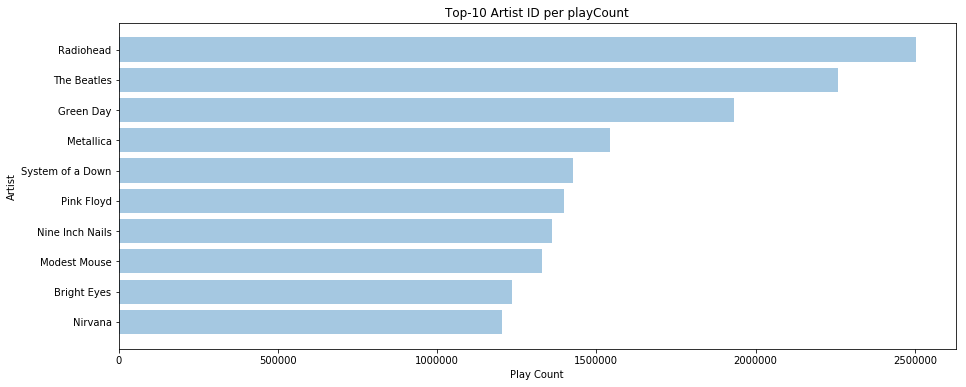

In [47]:
topArtistsAbsWithNames = top_10_artists_per_playCount(newUserArtistDF, 'Top-10 Artist ID per playCount')
topArtistsAbsWithNames = topArtistsAbsWithNames.cache() # get and cache the dataframe as it will be used later on

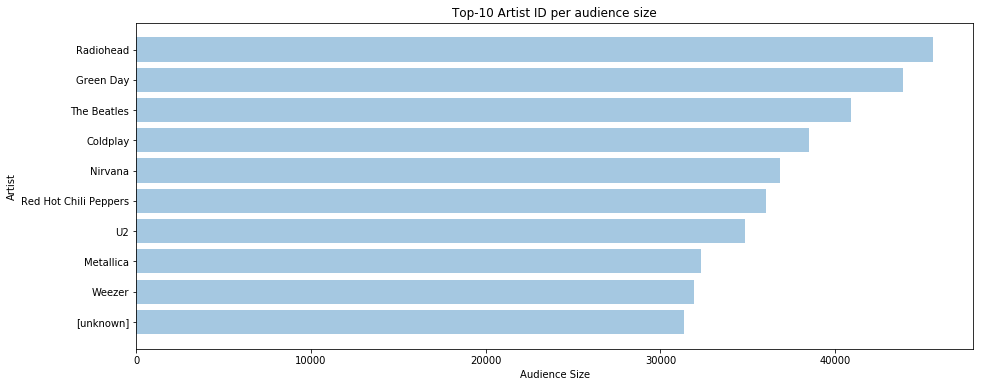

In [48]:
topArtistsAudWithNames = top_10_artists_per_audience(newUserArtistDF, 'Top-10 Artist ID per audience size')
topArtistsAudWithNames = topArtistsAudWithNames.cache() # get and cache the dataframe as it will be used later on

**COMMENT**<br>
First of all we have defined a function to plot a bar graph with the results. On the x axis it is represented the value of playCount or audience size, depending on the query. On the y axis it is represented the top-10 artistID in both cases. <br>
For the first query we just grouped by the artistID and summed the values of playCount. As a result we obtained the top-10 artists according to the absolute value of playCount.
For the second query we grouped by the artistID again and we counted the number of different users that listened to their songs at least ones for each of them. As a result we obtained the top-10 artists according to the audience size.

The plots demonstrates an existing correlation between the audience size and the play count because it is possible to notice that most of the artists are present in both of them; this is self-evident because we might expect that a very popular artist has also a big play count and viceversa.<br>
However, it is interesting to notice, for example, that "Green Day" seems to have a wider audience compared to "The Beatles" while this behaviour is inverted if we look at the play counts, or that "Pink Floys" is in top-10 artists for the play count but it's not in the top-10 for the audience size while "Coldplay" is in the top-10 for the audience but not for the play counts. This is reasonable as we may expect that some artist, as "Pink Floyd", or "The Beatles", which are older groups no more in action, are listened from always the same people, while others, as "Coldplay" or "Green Day", are still playing and are more popular nowadays, and so have a bigger audience especially between young people.

Another important thing to underline is the fact that the artist "[unknown]" came up from the audience size top-10 plot. This is not good for our recommendation system as it means that we are still dealing with "dirty" data. However it's good to know that as we will analyize its impact on the system later on.

#### ~Now repeat the same analysis with the "outliers-free" dataset

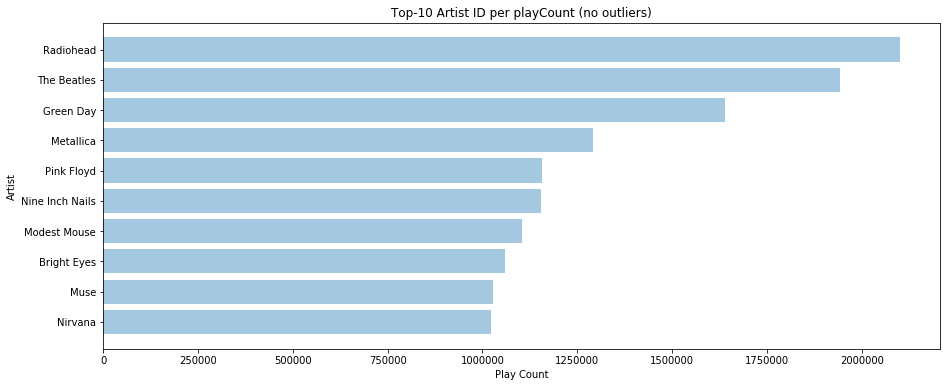

In [49]:
topArtistsAbswithoutOuliers = top_10_artists_per_playCount(newUserArtistDFwithoutOutliers, 'Top-10 Artist ID per playCount (no outliers)')
topArtistsAbswithoutOuliers = topArtistsAbswithoutOuliers.cache()

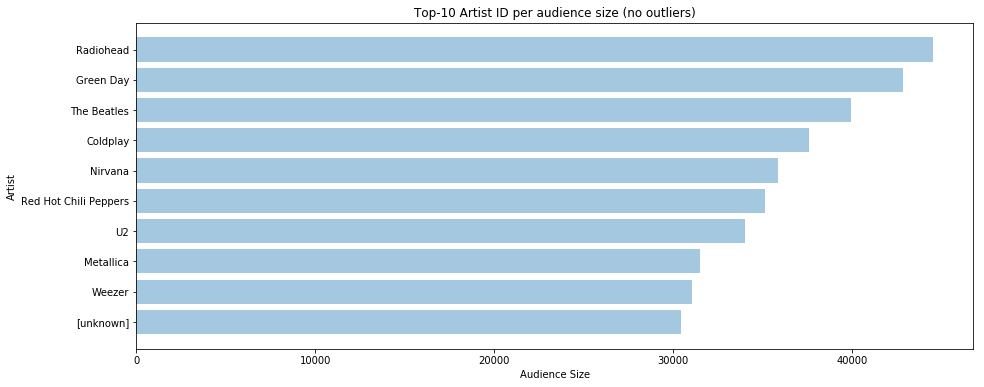

In [50]:
topArtistsAudwithoutOuliers = top_10_artists_per_audience(newUserArtistDFwithoutOutliers, 'Top-10 Artist ID per audience size (no outliers)')
topArtistsAudwithoutOuliers = topArtistsAudwithoutOuliers.cache()

**COMMENT**<br>
In this case there is no noticeable difference. The top tens are the same in both cases (play count and audience size), with and without the outliers. There may be very slight differences which will not influece the system behaviour.

#### Question 5.3

<div class="alert alert-info">
Who are the top-10 users?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "curiosity", that is, how many different artists they listened to</li>

</ul>  

Plot the results
</div>

In [51]:
def top_10_users_per_playCount(df, title):
    # calculate top 10 users interm of play counts
    topUsersAbs = df.groupBy('userID').agg(sum('playCount').alias('totPlayCount'))
    top10UsersAbs = topUsersAbs.orderBy('totPlayCount', ascending=0).take(10)
    plot_top10(top10UsersAbs, title, 'Play Count', 'User')
    return topUsersAbs

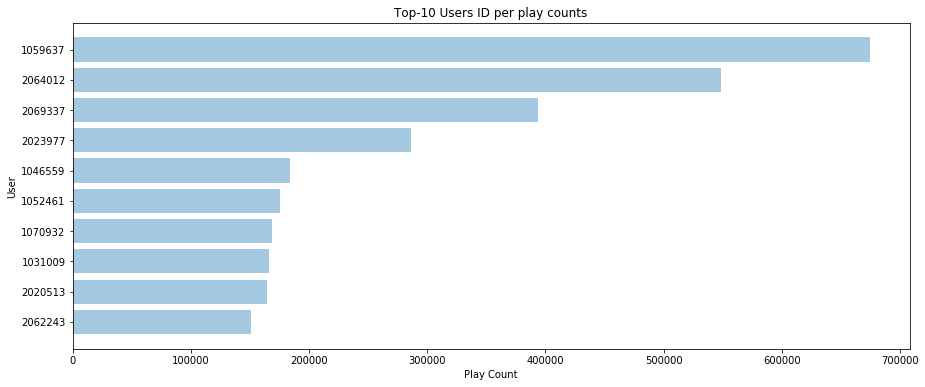

In [52]:
topUsersAbs = top_10_users_per_playCount(newUserArtistDF, 'Top-10 Users ID per play counts')
topUsersAbs = topUsersAbs.cache() # get and cache dataframe as it will be used later on

In [53]:
def top_10_users_per_curiosity(df, title):
    # calculate top 10 users in term of curiosity
    topUsersByCuriosity = df.groupBy('userID').agg(countDistinct('artistID').alias('curiosity'))
    top10UsersByCuriosity = topUsersByCuriosity.orderBy('curiosity', ascending=0).take(10)
    plot_top10(top10UsersByCuriosity, title, 'Number of Artists', 'User')
    return topUsersByCuriosity

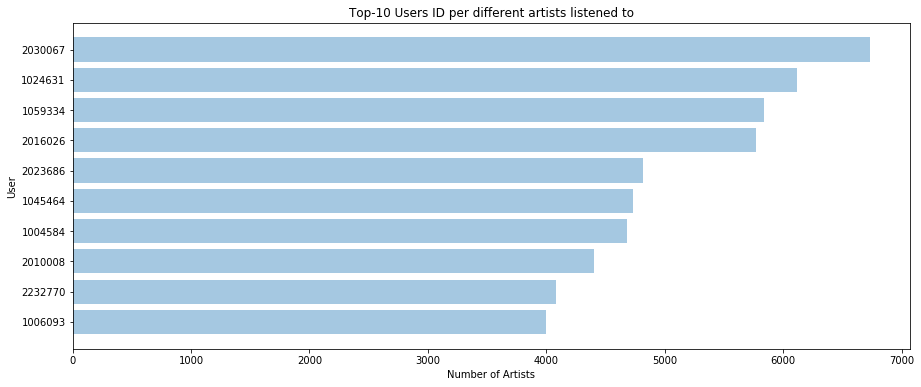

In [54]:
topUsersByCuriosity = top_10_users_per_curiosity(newUserArtistDF, 'Top-10 Users ID per different artists listened to')
topUsersByCuriosity = topUsersByCuriosity.cache() # get and cache dataframe as it will be used later on

**COMMENT**<br>
On the x axis it is represented the value of playCount or the artists count, depending on the query. On the y axis it is represented the top-10 userID in both cases.<br>
As before, for the first query we just grouped by the userID and summed the values of playCount. As a result we obtained the top-10 users according to the absolute value of playCount.
For the second query we grouped by the userID again and we counted the number of different artists each of them listened to. As a result we obtained the top-10 users according to their "curiosity".<br>
However in this case the plots did not demonstrate the same correlation as for the artists: users' curiosity and total play count are not related as well. In fact, at least for the top 10 users of this dataset, the ones with the highest play counts do not appear in the second plot; this could mean that those have an high play count just because they are used to listen always to the same songs and artists.

#### ~Now repeat the same analysis with the "outliers-free" dataset

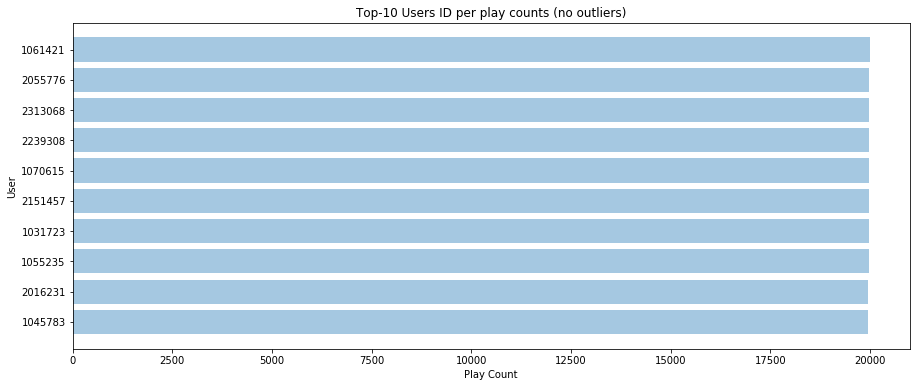

In [55]:
topUsersAbswithoutOutliers = top_10_users_per_playCount(newUserArtistDFwithoutOutliers, 'Top-10 Users ID per play counts (no outliers)')
topUsersAbswithoutOutliers = topUsersAbswithoutOutliers.cache()

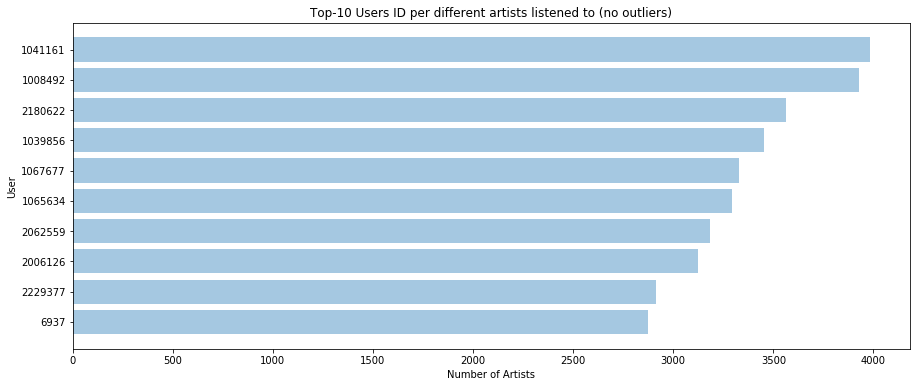

In [56]:
topUsersByCuriositywithoutOutliers = top_10_users_per_curiosity(newUserArtistDFwithoutOutliers, 'Top-10 Users ID per different artists listened to (no outliers)')
topUsersByCuriositywithoutOutliers = topUsersByCuriositywithoutOutliers.cache()

**COMMENT**<br>
Here the difference between the case with and without outliers are evident, as we are directly analyzing the top 10 users. As we have removed the "most active" users from our "outliers-free" dataset, obviously the first of the two plots results to be cut up at the value 20000, which is the one we have chosen as our outliers upperbound. In the second plot, instead, we can see a trend similar to the one above, but the users are different!

## In-depth analysis: audience size, curiosity and play counts

Until now we have studied users and artists by analyzing play counts, audience and curiosity. But it could be also interesting to analyze play counts by looking, for example, at the correlation that exists between the total number of played song per artist and the number of different users that listen to him.<br>
So the goal of this section is to go deeper into the analysis done until this point.

### PlayCount vs Audience

As we have said above, one interesting thing to notice is the ratio between the total play count per artist and his audience. In fact, if we consider the ratio audienceSize/playCount we obtain a value which indicates the "degree of loyalty" of the users towards a particular artist:
* the more this value is close to 0, the bigger is the fidelity of the users. This because it means that a "small portion" of users tends to listen again to that artist multiple time
* the more this it's close 1, the less is the users loyality. This because it means that users tends to listen to that artist only once (or few times), without playing back his songs anymore.

This ratio may give us a good index of the "appeal" of a certain artist, and, depending on the result, might be very useful to recommend (or avoid doing so) a song of the same artist right after it has been listened to one.<br>
For example, if we have an artist with a low index, we know that users tend to listen to him multiple times, so it might be a good idea to suggest one of his songs to a user which is listening to him for the first time. At the contrary, if an artist has a low index, a good recommendation would be to change it after the first plays.<br>
Moreover, it could be useful also to "group" artists. In fact, we might be interested in dividing the artists in subgroups, or clusters, in term of "audience diversity", which is not simply the audience size as it is but is a kind of normalization with respect to play count. If we simply look at the audience size, the smallest and unknown artists could be disadvantaged and it could be very difficult for them to "come to light"; while, in online/streaming services like this, people could be interested in finding new small artists, and in this way those may take advantage of such system.<br>
Analyzing the values from these tables it is also possible to measure how successful are artist's songs during the years. In fact there could be an artist whose songs are listened to many times also after years since their release, whereas other ones whose songs are only listened to in the period close to their first release.

In [57]:
#join artists
AudiencePlaycountDF = topArtistsAudWithNames.join(topArtistsAbsWithNames, ['artistID', 'name'])
AudiencePlaycountDF = AudiencePlaycountDF.withColumn('aud_PC_ratio', ((1.0*AudiencePlaycountDF.audience)/AudiencePlaycountDF.totPlayCount))
AudiencePlaycountDF.show()

+--------+--------------------+--------+------------+--------------------+
|artistID|                name|audience|totPlayCount|        aud_PC_ratio|
+--------+--------------------+--------+------------+--------------------+
|     111|            Calexico|    4740|       99394|0.047688995311588225|
|     133|            Submerge|      30|         228| 0.13157894736842105|
|     313|         David Bowie|   27170|      722031| 0.03762996325642528|
|     414|    Forgotten Rebels|      88|        1069|  0.0823199251637044|
|    1280|           Salt Tank|     965|        3549|  0.2719075795998873|
|    1292|       Stereophonics|   10296|      181277| 0.05679705643848916|
|    1413|   The Dandy Warhols|   12175|      204324| 0.05958673479375893|
|    1736|DJ Spooky That Su...|      88|         778| 0.11311053984575835|
|    2560|        Paul Schutze|      61|         398| 0.15326633165829145|
|    2934|              Fonica|     107|        1695| 0.06312684365781711|
|    3321|           Semi

In [58]:
# utility function that may be useful further on
def getArtistStats(artistID):
    return AudiencePlaycountDF[AudiencePlaycountDF.artistID == artistID].take(1)[0]

In [59]:
AudiencePlaycountDF.orderBy('totPlayCount', ascending=0).show()

+--------+--------------------+--------+------------+--------------------+
|artistID|                name|audience|totPlayCount|        aud_PC_ratio|
+--------+--------------------+--------+------------+--------------------+
|     979|           Radiohead|   45630|     2502596|0.018233066783452063|
| 1000113|         The Beatles|   40919|     2259825| 0.01810715431504652|
|    4267|           Green Day|   43883|     1931143| 0.02272384800089895|
| 1000024|           Metallica|   32337|     1543430|0.020951387494087842|
|    4468|    System of a Down|   27199|     1426254|0.019070235736411607|
|      82|          Pink Floyd|   30661|     1399665|0.021905956068059142|
|     831|     Nine Inch Nails|   25410|     1361977|0.018656702719649452|
| 1001779|        Modest Mouse|   27731|     1328969| 0.02086655143949934|
| 1000130|         Bright Eyes|   22159|     1234773|0.017945808662806848|
|     976|             Nirvana|   36823|     1203348| 0.03060045805535888|
| 1000139|               

In [60]:
AudiencePlaycountDF.orderBy('audience', ascending=0).show()

+--------+--------------------+--------+------------+--------------------+
|artistID|                name|audience|totPlayCount|        aud_PC_ratio|
+--------+--------------------+--------+------------+--------------------+
|     979|           Radiohead|   45630|     2502596|0.018233066783452063|
|    4267|           Green Day|   43883|     1931143| 0.02272384800089895|
| 1000113|         The Beatles|   40919|     2259825| 0.01810715431504652|
|    1177|            Coldplay|   38497|     1001417|0.038442526939326975|
|     976|             Nirvana|   36823|     1203348| 0.03060045805535888|
|    1274|Red Hot Chili Pep...|   36036|     1088701|  0.0330999971525699|
|    1205|                  U2|   34853|     1015494| 0.03432122691025255|
| 1000024|           Metallica|   32337|     1543430|0.020951387494087842|
|    3327|              Weezer|   31951|      977933|0.032671972415288165|
| 1034635|           [unknown]|   31324|      429447| 0.07294031626719945|
| 1231740|     Franz Ferd

In [61]:
AudiencePlaycountDF.filter('totPlayCount > 500').orderBy('aud_PC_ratio', ascending=0).show()

+--------+--------------------+--------+------------+-------------------+
|artistID|                name|audience|totPlayCount|       aud_PC_ratio|
+--------+--------------------+--------+------------+-------------------+
| 1031297|                 CLS|     277|         517| 0.5357833655705996|
| 1058030|            Davy DMX|     313|         587| 0.5332197614991482|
| 1009497|      Barrett Strong|     314|         606| 0.5181518151815182|
| 1236145|prodigy & tom mor...|     298|         601|0.49584026622296173|
| 1013370|               Mtume|     266|         550|0.48363636363636364|
|10705491|Ray Parker Jr. vs...|     343|         721|0.47572815533980584|
| 1048726|          MUSICMATCH|     418|         881|0.47446083995459704|
| 1244987| The Peasall Sisters|     257|         543| 0.4732965009208103|
|    3898|              Hashim|     408|         863| 0.4727694090382387|
| 1032996|          Bobby Byrd|     719|        1523|0.47209455022980956|
| 1245010|James Carter & Th...|     56

Here it is not useful to show the top artists per audience ratio as all artists with a very low play count (==1) would be shown. So we filtered the artists to show only those with a playcount > 500.

In [62]:
AudiencePlaycountDF.orderBy('aud_PC_ratio', ascending=1).show()

+--------+--------------------+--------+------------+--------------------+
|artistID|                name|audience|totPlayCount|        aud_PC_ratio|
+--------+--------------------+--------+------------+--------------------+
|10107235|      Crime brothers|       1|        5841|1.712035610340695E-4|
| 6901343|           Music 205|       6|       26132|2.296035512015919...|
|10659711|               Tzigg|       1|        4275|2.339181286549707...|
| 6859228|      Josh Rosenblum|       1|        4004|2.497502497502497...|
|10508734|Killswitch Engage...|       1|        3988|2.507522567703109...|
| 6730413|   Geographic Empire|       1|        3895|2.567394094993581...|
| 6706174|Jack and the Fant...|       1|        3770|2.652519893899204E-4|
| 9988956|        Dirt & Nazir|       1|        3222|3.103662321539416...|
|10281600|       lizkar, crazy|       1|        3195|3.129890453834115...|
| 6814959|International Gat...|       1|        3149|3.175611305176246...|
| 9988950|    Pinnacle Rh

From the tables above it's possible to see the different relations between the top/worst artists and the related play counts and audience size. It's funny to notice that there are artists with an audience size = 1, which means that there is only one person that listens to that artist, and whose audience/count ratio in some cases could be very low because of the high play count. For example "Crime brothers" has a play count of 5841 and an audience of 1 person. In other cases it happens that the audience/count ratio is equal to 1 but this results from an unique person that listened to that artist once.

Above we have noticed an existing correlation between audience size and play counts as half of the artists which are present in the top-10 for audience size are also present in the top-10 for play count. But is this kind of correlation true in general?

In [63]:
def twin_plot(data, title, xlabel, ylabel1, ylabel2):
    x = np.arange(len(data[:,0]))

    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.plot(x, data[:,1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel2, color='b')
    ax2 = ax.twinx()
    ax2.plot(x, data[:,0], 'r')
    ax2.set_ylabel(ylabel1, color='r')
    plt.show()

In [64]:
data = AudiencePlaycountDF.orderBy('audience').select('audience', 'totPlayCount').collect()
data = np.array(data)

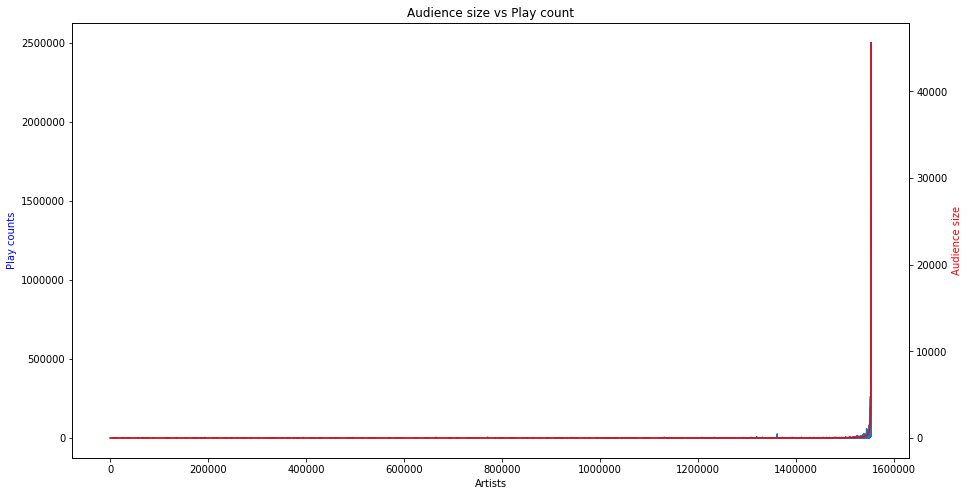

In [65]:
twin_plot(data, "Audience size vs Play count", "Artists", "Audience size", "Play counts")

**COMMENT**<br>
In order to better visualize this possible correlation we have produced a twin plot: shared x axis with the artists (ordered by audience in this case just to show the increasing in both the curves), two y axis, one for the audience size (in red) and one for the play count (in blue).

Here it is evident the fact that the trends that the play count and audience size assume are very similar to each other: the blu and the red lines are on each other.

In [66]:
def scatter_plot(data, title, xlabel, ylabel, outliers=None):
    plt.figure(figsize=(15,10) )
    p = plt.scatter(data[:,0], data[:,1])
    if(outliers is not None):
        o = plt.scatter(outliers[:,0], outliers[:,1], color='red')
        plt.legend((p,o),
           ('Data point', 'Outlier'),
           loc='upper right',
           fontsize=8)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

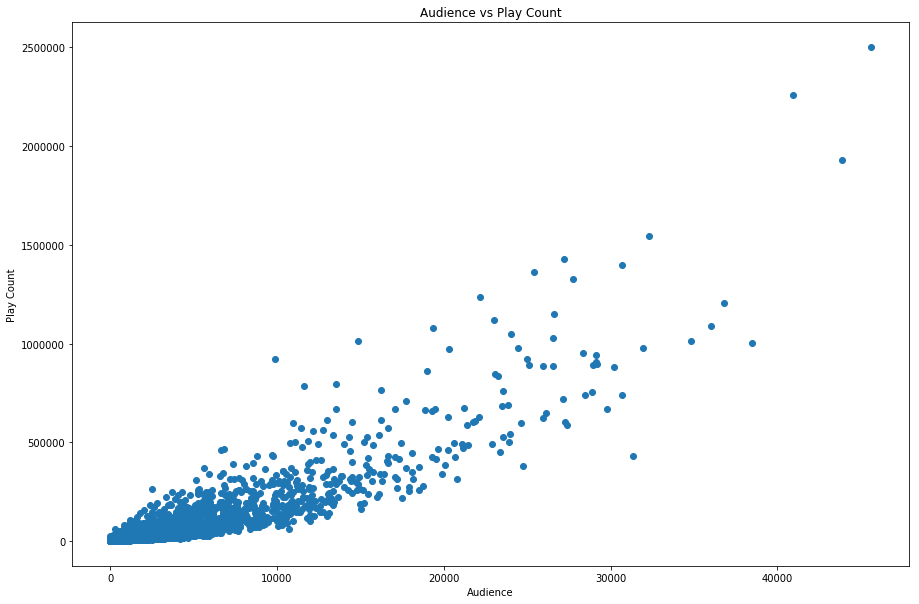

In [67]:
scatter_plot(data, "Audience vs Play Count", "Audience", "Play Count")

**COMMENT**<br>
Here instead we wanted to show a graphical representation of this ratio. The correlation is noticeable by looking at how the point are distributed around the diagonal line. This means that, in general, when the play count increase also the audience will increase (and viceversa).


At this point we expect that we won't find the same correlation also for the curiosity and play count.

### PlayCount vs Curiosity

The same analysis done for the artists can be done in the same way for the users. In this case, an important index could be the ratio curiosity/playCounts, which tell us what is the "curiosity" of the user with respect to the total songs he has listened to. This could be very useful, as before, in case we are interested in classifing/dividing the users in subgroups/clusters, so that also the "smallest users", the ones which have a very poor interaction with the system, can be suggested and recommended.

In [68]:
curiosityPlaycountDF = topUsersByCuriosity.join(topUsersAbs, ['userID'])
curiosityPlaycountDF = curiosityPlaycountDF.withColumn('curiosity_PC_ratio', ((1.0*curiosityPlaycountDF.curiosity)/curiosityPlaycountDF.totPlayCount))
curiosityPlaycountDF.show()

+-------+---------+------------+--------------------+
| userID|curiosity|totPlayCount|  curiosity_PC_ratio|
+-------+---------+------------+--------------------+
|1000061|      111|         244| 0.45491803278688525|
|1000070|      133|       20200|0.006584158415841584|
|1000313|       26|         197|  0.1319796954314721|
|1000832|      259|        1064| 0.24342105263157895|
|1000905|       18|         214| 0.08411214953271028|
|1001372|      229|        1329| 0.17231000752445447|
|1001409|      317|       18663|0.016985479290574933|
|1001530|      701|        3011| 0.23281301893058784|
|1001700|      154|         608|  0.2532894736842105|
|1001731|      823|        4478| 0.18378740509155872|
|1001753|      794|        7742|  0.1025574786876776|
|1001872|      518|        9087|0.057004511940134256|
|1002159|      196|        1303| 0.15042210283960092|
|1002420|     1033|       10232| 0.10095777951524629|
|1002519|       29|         510|0.056862745098039215|
|1002734|        8|         

In [69]:
# utility function that may be useful later on
def getUserStats(user):
    return curiosityPlaycountDF[curiosityPlaycountDF.userID == user].take(1)[0]

In [70]:
curiosityPlaycountDF.orderBy('totPlayCount', ascending=0).show()

+-------+---------+------------+--------------------+
| userID|curiosity|totPlayCount|  curiosity_PC_ratio|
+-------+---------+------------+--------------------+
|1059637|      359|      674412|5.323155578489114E-4|
|2064012|       57|      548427|1.039336137717508...|
|2069337|      256|      393454|6.506478520996101E-4|
|2023977|       67|      285978|2.342837560931260...|
|1046559|     1066|      183867|0.005797668967242627|
|1052461|      239|      175634|0.001360784358381...|
|1070932|      120|      168977|7.101558200228433E-4|
|1031009|      736|      166109|0.004430825542264417|
|2020513|      121|      164649|7.348966589532885E-4|
|2062243|      740|      151110|0.004897094831579644|
|2069889|      231|      143092|0.001614346015151...|
|2014936|      396|      135264|0.002927608232789...|
|2017397|       72|      134032|5.371851498149696E-4|
|1001440|     2429|      133825|0.018150569773958528|
|1024631|     6119|      122067| 0.05012820827905986|
|1007308|      548|      111

In [71]:
curiosityPlaycountDF.orderBy('curiosity', ascending=0).show()

+-------+---------+------------+--------------------+
| userID|curiosity|totPlayCount|  curiosity_PC_ratio|
+-------+---------+------------+--------------------+
|2030067|     6730|       23038|  0.2921260526087334|
|1024631|     6119|      122067| 0.05012820827905986|
|1059334|     5837|       80469|  0.0725372503697076|
|2016026|     5770|       58921| 0.09792773374518422|
|2023686|     4815|       80408|0.059882101283454385|
|1045464|     4732|       53167| 0.08900257678635244|
|1004584|     4685|       35051| 0.13366237767824027|
|2010008|     4406|       77420|   0.056910359080341|
|2232770|     4084|       20610| 0.19815623483745753|
|1006093|     4001|       20586| 0.19435538715631984|
|1041161|     3982|       18324|   0.217310630866623|
|1008492|     3930|       17796|  0.2208361429534727|
|1063488|     3785|       35195| 0.10754368518255435|
|1063027|     3776|       22075| 0.17105322763306907|
|2180622|     3565|       16303| 0.21867141016990738|
|1021112|     3552|       32

In [72]:
curiosityPlaycountDF.filter('totPlayCount > 500').orderBy('curiosity_PC_ratio', ascending=0).show()

+-------+---------+------------+------------------+
| userID|curiosity|totPlayCount|curiosity_PC_ratio|
+-------+---------+------------+------------------+
|2311890|      521|         607|0.8583196046128501|
|1005526|      447|         644|0.6940993788819876|
|1017443|      619|         899|0.6885428253615128|
|2038628|      436|         647|0.6738794435857806|
|2345728|      452|         671|0.6736214605067065|
|2173190|      440|         655|0.6717557251908397|
|2247570|      535|         803|0.6662515566625156|
|2268418|      397|         597|0.6649916247906198|
|1000320|      662|         998|0.6633266533066132|
|2174427|      748|        1128|0.6631205673758865|
|2186437|      433|         662|0.6540785498489426|
|2061101|      457|         700|0.6528571428571428|
|2111169|      373|         572|0.6520979020979021|
|1031842|      359|         552|0.6503623188405797|
|2006706|      451|         697|0.6470588235294118|
|2003880|      760|        1178|0.6451612903225806|
|2402282|   

Here it is not useful to show the top users per curiosity ratio as all users with a very low play count (==1) would be shown. So we filtered the users to show only thise with a playcount > 500, so that it's easier to make suggestions.

In [73]:
curiosityPlaycountDF.orderBy('curiosity_PC_ratio', ascending=1).show()

+-------+---------+------------+--------------------+
| userID|curiosity|totPlayCount|  curiosity_PC_ratio|
+-------+---------+------------+--------------------+
|2064012|       57|      548427|1.039336137717508...|
|2217459|        2|       16891|1.184062518500976...|
|2043762|        6|       31112|1.928516328104911...|
|2023977|       67|      285978|2.342837560931260...|
|2259459|        2|        8440|2.369668246445497...|
|2328582|        2|        5613|3.563156957063959E-4|
|1047928|        1|        1909|5.238344683080147E-4|
|1059637|      359|      674412|5.323155578489114E-4|
|2017397|       72|      134032|5.371851498149696E-4|
|1073616|       24|       42464|5.651846269781462E-4|
|2401770|        4|        6477|6.175698625907056E-4|
|2425358|        1|        1582|6.321112515802782E-4|
|2069337|      256|      393454|6.506478520996101E-4|
|1010364|        3|        4441|6.755235307363207E-4|
|2136969|        2|        2923|6.842285323297981E-4|
|1070932|      120|      168

In the same way as before, now we want to try to confirm/confute what we have guessed above: apparently there is no correlation between the curiosity and the play counts as none of the users present in the top-10 for curiosity is also present in the top-10 for play count. But is this true in general?

In [74]:
data = curiosityPlaycountDF.orderBy('curiosity').select('curiosity', 'totPlayCount').collect()
data = np.array(data)

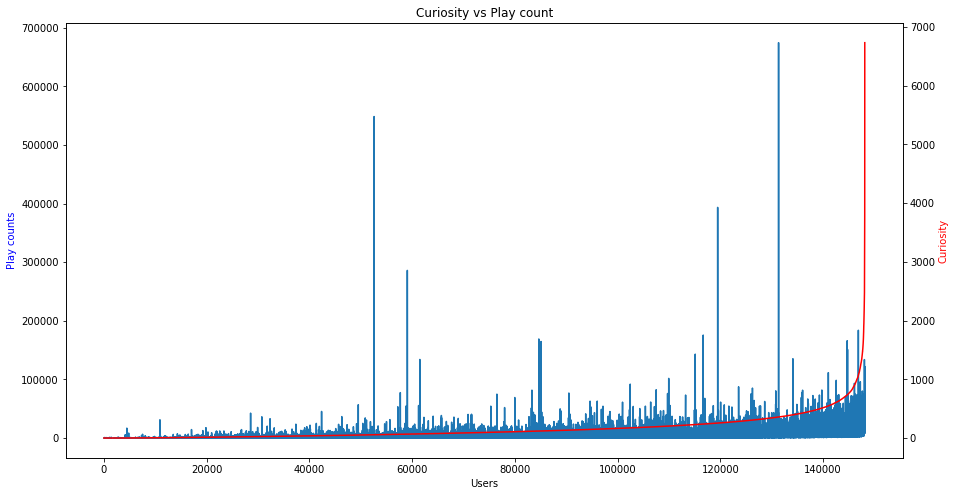

In [75]:
twin_plot(data, "Curiosity vs Play count", "Users", "Curiosity", "Play counts")

**COMMENT**<br>
Also in this case we have produced a twin plot: shared x axis with the users (ordered by audience in this case just to show the decreasing in both the curves), two y axis, one for the curiosity (in red) and one for the play count (in blue).

Contrarily to what we found for Audience vs Play count, in this case the trends of the two curves are clearly completely uncorrelated. As before, the data have been ordered by curiosity in this case, and it's evident how the play count "curve" is compleately different. There are, in fact, a lot of users which have a very low curiosity, but a very high play count at the same time.

NB: for this plot we have used the "normal" df version, not the one without outliers. Obviously the results would have been the same, with the blu lines cut on the top, resulting in a "zoomed" version of the plot, filled with vertical blu lines.

In [76]:
# for computing outliers, just repeat the same operations as above on the dataframe and subtract the two
curiosityPlaycountDFwithoutOutliers = topUsersByCuriositywithoutOutliers.join(topUsersAbswithoutOutliers, ['userID'])

outliersDF = curiosityPlaycountDF.join(curiosityPlaycountDFwithoutOutliers, ['userID'], 'leftanti')
outliers_data = outliersDF.select('curiosity', 'totPlayCount').collect()
outliers_data = np.array(outliers_data)

# then we need
data = curiosityPlaycountDFwithoutOutliers.select('curiosity', 'totPlayCount').collect()
data = np.array(data)

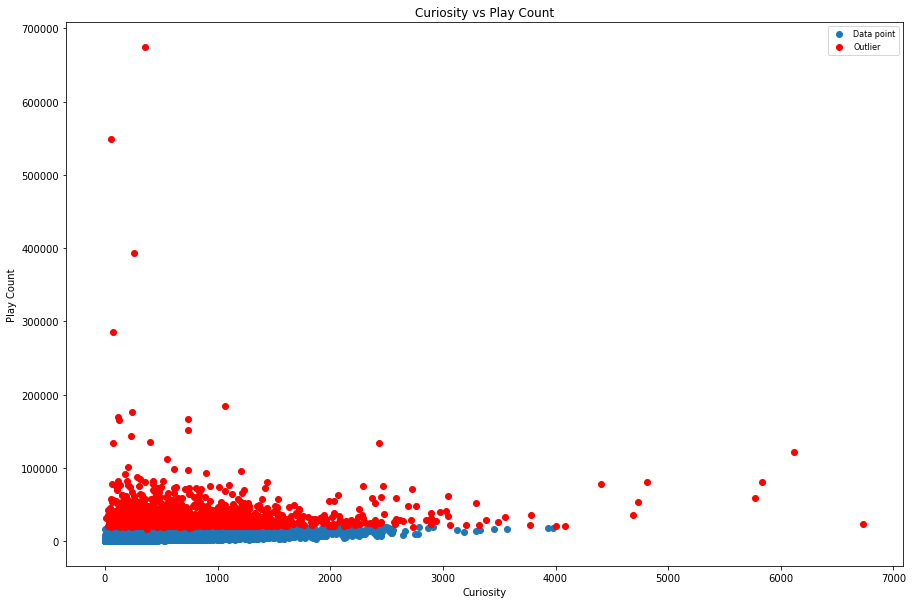

In [77]:
scatter_plot(data, "Curiosity vs Play Count", "Curiosity", "Play Count", outliers=outliers_data)

This is the same plot showed above for the audience vs playcount, in this case obviously representing curiosity vs playcounts. However, here we wanted also to put (a visive) evidence of the contrast between outliers and standard points. It may appears that the number of outliers is greater than the data points, but it is not like that as the outliers are much more "sparse".

Given the plot above, we can confirm what we have guessed when we discussed about the top 10 artists and users per playcount, curiosity and audience (Question 5): there is not a correlation between curiosity and play count, while there is a correlation between audience and play count. In fact, unlike the scatter plot 'Audience vs Play Count', in this case the points are not concentrated around the main diagonal, but along the two axis.

Now we have some valuable information about the data. It's the time to study how to build a statistical models.

# 2. Build a statistical models to make recommendations

## 2.1 Introduction to recommender systems

In a recommendation-system application there are two classes of entities, which we shall refer to as `users` and `items`. Users have preferences for certain items, and these preferences must be inferred from the data. The data itself is represented as a `preference matrix` $A$, giving for each user-item pair, a value that represents what is known about the degree of preference of that user for that item. The table below is an example for a `preference matrix` of 5 users and `k` items. The `preference matrix` is also known as `utility matrix`.

| | IT1 | IT2 | IT3 | ... | ITk |
|---|---|---|---|---|---|
| U1 | 1 |  | 5 | ... | 3 |
| U2 |  | 2 |  | ... | 2 |
| U3 | 5 |  | 3 | ... |  |
| U4 | 3 | 3 |  | ... | 4 |
| U5 |  | 1 |  | ... | ... |

The value of row i, column j expresses how much does user `i` like item `j`. The values are often the rating scores of users for items. An unknown value implies that we have no explicit information about the user's preference for the item. The goal of a recommendation system is to predict "the blanks" in the `preference matrix`. For example, assume that the rating score is from 1 (dislike) to 5 (love), would user `U5` like `IT3` ? We have two approaches:

* Designing our recommendation system to take into account properties of items such as brand, category, price... or even the similarity of their names. We can denote the similarity of items `IT2` and `IT3`, and then conclude that because user `U5` did not like `IT2`, they were unlikely to enjoy SW2 either.

* We might observe that the people who rated both `IT2` and `IT3` tended to give them similar ratings. Thus, we could conclude that user `U5` would also give `IT3` a low rating, similar to `U5`'s rating of `IT2`

It is not necessary to predict every blank entry in a `utility matrix`. Rather, it is only necessary to discover some entries in each row that are likely to be high. In most applications, the recommendation system does not oﬀer users a ranking of all items, but rather suggests a few that the user should value highly. It may not even be necessary to ﬁnd all items with the highest expected ratings, but only to ﬁnd a large subset of those with the highest ratings.


## 2.2 Families of recommender systems

In general, recommender systems can be categorized into two groups:

* **Content-Based** systems focus on properties of items. Similarity of items is determined by measuring the similarity in their properties.

* **Collaborative-Filtering** systems focus on the relationship between users and items. Similarity of items is determined by the similarity of the ratings of those items by the users who have rated both items.

In the usecase of this notebook, artists take the role of `items`, and `users` keep the same role as `users`.
Since we have no information about `artists`, except their names, we cannot build a `content-based` recommender system.

Therefore, in the rest of this notebook, we only focus on `Collaborative-Filtering` algorithms.

## 2.3 Collaborative-Filtering 
In this section, we study a member of a broad class of algorithms called `latent-factor` models. They try to explain observed interactions between large numbers of users and products through a relatively small number of unobserved, underlying reasons. It is analogous to explaining why millions of people buy a particular few of thousands of possible albums by describing users and albums in terms of tastes for perhaps tens of genres, tastes which are **not directly observable or given** as data. 

First, we formulate the learning problem as a matrix completion problem. Then, we will use a type of `matrix factorization` model to "fill in" the blanks.  We are given implicit ratings that users have given certain items (that is, the number of times they played a particular artist) and our goal is to predict their ratings for the rest of the items. Formally, if there are $n$ users and $m$ items, we are given an $n \times m$ matrix $R$ in which the generic entry $(u, i)$ represents the rating for item $i$ by user $u$. **Matrix $R$ has many missing entries indicating unobserved ratings, and our task is to estimate these unobserved ratings**.

A popular approach to the matrix completion problem is **matrix factorization**, where we want to "summarize" users and items with their **latent factors**.

### 2.3.1 Basic idea and an example of Matrix Factorization
For example, given a preference matrix 5x5 as below, we want to approximate this matrix into the product of two smaller matrixes $X$ and $Y$ .

$$
M = 
\begin{bmatrix}
 5 & 2 & 4 & 4 & 3 \\
 3 & 1 & 2 & 4 & 1 \\
 2 &  & 3 & 1 & 4 \\
 2 & 5 & 4 & 3 & 5 \\
 4 & 4 & 5 & 4 &  \\
\end{bmatrix}
\approx M^\prime =
\begin{bmatrix}
 x_{11} & x_{12} \\
 x_{21} & x_{22} \\
 x_{31} & x_{32} \\
 x_{41} & x_{42} \\
 x_{51} & x_{52} \\
\end{bmatrix}
\times
\begin{bmatrix}
 y_{11} & y_{12} & y_{13} & y_{14} & y_{15} \\
 y_{21} & y_{22} & y_{23} & y_{24} & y_{25} \\
\end{bmatrix}
$$

$M^\prime$ is an approximation that is as close to A as possible. To calculate how far from $M$ $M^\prime$ is, we often calculate the sum of squared distances of non-empty elements in $M$ and the corresponding elements in $M^\prime$.
In this way, for $M^\prime$, besides the approximated elements in $M$, we also have the non-observed elements. Therefore, to see how much does user `i` like item `j`, we simply pick up the value of $M^\prime_{i,j}$.

The challenge is how to calculate $X$ and $Y$. The bad news is that this can't be solved directly for both the best $X$ and best $Y$ at the same time. Fortunately, if $Y$ is known, we can calculate the best of $X$, and vice versa. It means from the initial values of $X$ and $Y$ in the beginning, we calculate the best $X$ according to $Y$, and then calculate the best $Y$ according to the new $X$. This process is repeated until the distance from $XY$ to $M$ is small. It's simple, right ?

Let's take an example. To compute the approximation for the above 5x5 matrix $M$, first, we initialize the value of $X$ and $Y$ as below.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

With the initial iteration, we calculate the the Root-Mean-Square Error from $XY$ to $M$.

Consider the ﬁrst rows of $M$ and $XY$ . We subtract the first row of $XY$ from the entries in the ﬁrst row of $M$, to get $3,0,2,2,1$. We square and sum these to get $18$. 

In the second row, we do the same to get $1,−1,0,2,−1$, square and sum to get $7$. 

In the third row, the second column is blank, so that entry is ignored when computing the RMSE. The diﬀerences are $0,1,−1,2$ and the sum of squares is $6$. 

For the fourth row, the diﬀerences are $0,3,2,1,3$ and the sum of squares is $23$. 

The ﬁfth row has a blank entry in the last column, so the diﬀerences are $2,2,3,2$ and the sum of squares is $21$. 

When we sum the sums from each of the ﬁve rows, we get $18+7+6+23+21 = 75$. So, $RMSE=\sqrt{75/23}=1.806$ where $23$ is the number of non-empty values in $M$.

Next, with the given value of $Y$, we calculate $X$ by finding the best value for $X_{11}$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 x & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 x+1 & x+1 & x+1 & x+1 & x+1 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

Now, to minimize the $RMSE$  we minimize the difference of the first rows $(5−(x+1))^2 + (2−(x+1))^2 + (4−(x+1))^2 + (4−(x+1))^2 + (3−(x+1))^2$. By  taking the derivative and set that equal to 0, we pick $x=2.6$

Given the new value of $X$, we can calculate the best value for $Y$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 2.6 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 y & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 3.6 & 3.6 & 3.6 & 3.6 & 3.6 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

By doing the same process as before, we can pick value for $y=1.617$. After that, we can check if the $RMSE$ is not converged, we continue to update $X$ by $Y$ and vice versa. In this example, for simple, we only update one element of each matrix in each iteration. In practice, we can update a full row or full matrix at once.


### 2.3.2 Matrix Factorization: Objective and ALS Algorithm on a Single Machine

More formally, in general, we select $k$ latent features, and describe each user $u$ with a $k-$dimensional vector $x_u$, and each item $i$ with a $k-$dimensional vector $y_i$.

Then, to predict user $u$'s rating for item $i$, we do as follows: $ r_{ui} \approx x_{u}^{T}y_i$.

This can be put, more elegantly, in a matrix form. Let $x_1, \cdots x_n \in \mathbb{R}^k$ be the factors for the users, and $y_1, \cdots y_m \in \mathbb{R}^k$ the factors for the items. The $k \times n$ user matrix $X$ and the $k \times m$ item matrix $Y$ are then defined by:

$$
X = 
\begin{bmatrix}
 |   &         & |  \\
x_1  &  \cdots & x_n\\
 |   &         & |  \\
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
 |   &         & |  \\
y_1  &  \cdots & y_i\\
 |   &         & |  \\
\end{bmatrix}
$$

Our goal is to estimate the complete ratings matrix $R \approx X^{T} Y$. We can formulate this problem as an optimization problem in which we aim to minimize an objective function and find optimal $X$ and $Y$ . In particular, we aim to minimize the least squares error of the observed ratings (and regularize):

$$
\min_{X,Y} \sum_{r_{ui} \text{observed}}(r_{ui} - x_{u}^{T}y_i)^2 + \lambda \left( \sum_{u} \|x_u\|^2 + \sum_{i} \|y_i\|^2 \right) 
$$

Notice that this objective is non-convex (because of the $x_{u}^{T} y_i$ term); in fact it’s NP-hard to optimize. Gradient descent can be used as an approximate approach here, however it turns out to be slow and costs lots of iterations. Note however, that if we fix the set of variables $X$ and treat them as constants, then the objective is a convex function of $Y$ and vice versa. Our approach will therefore be to fix $Y$ and optimize $X$, then fix $X$ and optimize $Y$, and repeat until convergence. This approach is known as **ALS (Alternating Least Squares)**. For our objective function, the alternating least squares algorithm can be expressed with this simple pseudo-code:


**Initialize** $X$, $Y$

**while(convergence is not true) do**


**for** $u = 1 \cdots n$ **do**

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 
   
**end for**

**for** $u = 1 \cdots n$ **do**

$y_i = \left( \sum_{r_ui \in r_{*i}} x_u x_{u}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{*i}} r_{ui} x_u $ 
   
**end for**


**end while**


For a single machine, we can analyze the computational cost of this algorithm. Updating each $x_u$ will cost $O(n_u k^2 + k^3)$, where $n_u$ is the number of items rated by user $u$, and similarly updating each $y_i$ will cost $O(n_i k^2 + k^3)$, where $n_i$ is the number of users that have rated item $i$.


Once we’ve computed the matrices $X$ and $Y$, there are several ways compute a prediction. The first is to do what was discussed before, which is to simply predict $ r_{ui} \approx x_{u}^{T}y_i$ for each user $u$ and item $i$. 
This approach will cost $O(nmk)$ if we’d like to estimate every user-item pair. 

However, this approach is prohibitively expensive for most real-world datasets. A second (and more holistic) approach is to use the $x_u$ and $y_i$ as features in another learning algorithm, incorporating these features with others that are relevant to the prediction task.

### 2.3.3 Parallel Altenating Least Squares

There are several ways to distribute the computation of the ALS algorithm depending on how data is partitioned.

#### Method 1: using joins
First we consider a fully distributed version, in the sense that all data (both input and output) is stored in a distributed file system. In practice, input data (ratings) and parameters ($X$ and $Y$) are stored in an a Spark RDD. Specifically, ratings -- that are always **sparse** -- are stored as RDD of triplets:

Ratings: RDD((u, i, $r_{ui}$), . . . )


Instead, we can use dense representation for factor matrices $X$ and $Y$, and these are stored as RDDs of vectors. More precisely, we can use the data types introduced in Spark MLLib to store such vectors and matrices:

X : RDD($x_1$,...,$x_n$)

Y : RDD($y_1$,...,$y_m$)


Now, recall the expression to compute $x_u$:

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 

Let's call the first summation *part A* and the second summation *part B*. To compute such parts, in parallel, we can proceed with the following high-level pseudocode:

* Join the Ratings RDD with the $Y$ matrix RDD using key $i$ (items)
* Map to compute $y_i y_{i}^{T}$ and emit using key $u$ (user)
* ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} y_i y_{i}^{T}$
* Invert
* Another ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} r_{ui} y_i$

We can use the same template to copmute $y_i$.

This approach works fine, but note it requires computing $y_i y_{i}^{T}$ for each user that has rated item $i$. 

#### Method 2: using broadcast variables (advanced topic)
The next approach takes advantage of the fact that the $X$ and $Y$ factor matrices are often very small and can be stored locally on each machine.

* Partition the Ratings RDD **by user** to create $R_1$, and similarly partition the Ratings RDD **by item** to create $R_2$. This means there are two copies of the same Ratings RDD, albeit with different partitionings. In $R_1$, all ratings by the same user are on the same machine, and in $R_2$ all ratings for same item are on the same machine.
* Broadcast the matrices $X$ and $Y$. Note that these matrices are not RDD of vectors: they are now "local: matrices.
* Using $R_1$ and $Y$, we can use expression $x_u$ from above to compute the update of $x_u$ locally on each machine
* Using $R_2$ and $X$, we can use expression $y_i$ from above to compute the update of $y_i$ locally on each machine

A further optimization to this method is to group the $X$ and $Y$ factors matrices into blocks (user blocks and item blocks) and reduce the communication by only sending to each machine the block of users (or items) that are needed to compute the updates at that machine. 

This method is called **Block ALS**. It is achieved by precomputing some information about the ratings matrix to determine the "out-links" of each user (which blocks of the items it will contribute to) and "in-link" information for each item (which of the factor vectors it receives from each user block it will depend on). For exmple, assume that machine 1 is responsible for users 1,2,...,37: these will be block 1 of users. The items rated by these users are block 1 of items. Only the factors of block 1 of users and block 1 of items will be broadcasted to machine 1.

### Further readings
Other methods for matrix factorization include:

* Low Rank Approximation and Regression in Input Sparsity Time, by Kenneth L. Clarkson, David P. Woodruff. http://arxiv.org/abs/1207.6365
* Generalized Low Rank Models (GLRM), by Madeleine Udell, Corinne Horn, Reza Zadeh, Stephen Boyd. http://arxiv.org/abs/1410.0342
* Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares, by Trevor Hastie, Rahul Mazumder, Jason D. Lee, Reza Zadeh . Statistics Department and ICME, Stanford University, 2014. http://stanford.edu/~rezab/papers/fastals.pdf

# 3. Usecase : Music recommender system

In this usecase, we use the data of users and artists in the previous sections to build a statistical model to recommend artists for users.
 
## 3.1 Requirements
According to the properties of data, we need to choose a recommender algorithm that is suitable for this implicit feedback data. It means that the algorithm should learn without access to user or artist attributes such as age, genre,.... Therefore, an algorithm of type `collaborative filtering` is the best choice.

Second, in the data, there are some users that have listened to only 1 artist. We need an algorithm that might provide decent recommendations to even these users. After all, at some point, every user starts out with just one play at some point! 

Third, we need an algorithm that scales, both in its ability to build large models, and to create recommendations quickly. So, an algorithm which can run on a distributed system (SPARK, Hadoop...) is very suitable.

From these requirement, we can choose using ALS algorithm in SPARK's MLLIB.

Spark MLlib’s ALS implementation draws on ideas from [1](http://yifanhu.net/PUB/cf.pdf) and [2](http://link.springer.com/chapter/10.1007%2F978-3-540-68880-8_32).

## 3.2 Notes

Currently, MLLIB can only build models from an RDD. That means we have two ways to prepare data:

* Loading to into SPARK SQL DataFrame as before, and then access the corresponding RDD by calling `<dataframe>.rdd`. The invalid data is often sucessfully dropped by using mode `DROPMALFORMED`. However, this way might not work in all cases. Fortunately, we can use it with this usecase.

* Loading data directly to RDD. However, we have to deal with the invalid data ourself. In the trade-off, this way is the most reliable, and can work in every case.

In this notebook, we will use the second approach: it requires a bit more effort, but the reward is worth it!

 
## 3.3 Cleanup the data
In section 1, we already replaced the ids of mispelled artists by the corresponding standard ids by using SPARK SQL API.
However, if the data has the invalid entries such that SPARK SQL API is stuck, the best way to work with it is using an RDD.

Just as a recall, we work with three datasets in `user_artist_data.txt`, `` and `artist_alias.txt`. The entries in these file can be empty or have only one field. 

In details our goal now is:

* Read the input ```user_artist_data.txt``` and transforms its representation into an output dataset.
* To produce an output "tuple" containing the original user identifier and play counts, but with the artist identifier replaced by its most common alias, as found in the ```artist_alias.txt``` dataset.
* Since the ```artist_alias.txt``` file is small, we can use a technique called **broadcast variables** to make such transformation more efficient.


### Question 6

#### Question 6.1

<div class="alert alert-info">
Load data from `/datasets/lastfm/artist_alias.txt` and filter out the invalid entries to construct a dictionary to map from mispelled artists' ids to standard ids.
</div>

NOTE: From now on, we will use the "standard" data to train our model.

HINT: If a line contains less than 2 fields or contains invalid numerial values, we can return a special tuple. After that, we can filter out these special tuples.

In [14]:
rawArtistAlias = sc.textFile(base + "artist_alias.txt")

def xtractFields(s):
    # Using white space or tab character as separators,
    # split a line into list of strings 
    line = re.split("\s|\t",s,1)
    # if this line has at least 2 characters
    if (len(line) > 1):
        try:
            # try to parse the first and the second components to integer type
            return (int(line[0]), int(line[1]))
        except ValueError:
            # if parsing has any error, return a special tuple
            return (-1,-1)
    else:
        # if this line has less than 2 characters, return a special tuple
        return (-1,-1)

artistAlias = (
                rawArtistAlias
                    # extract fields using function xtractFields
                    .map(xtractFields)
    
                    # filter out the special tuples
                    .filter(lambda x: x[0] != -1 and x[1] != -1)
    
                    # collect result to the driver as a "dictionary"
                    .collectAsMap()
                )

### Cleaning

In [6]:
# reapply the same cleaning procedure showed above to the alias map
print("Removed", removeMirrors(artistAlias), "mirrored ids")
print("Removed", cleanAliasMap(artistAlias), "chained ids")

Removed 11 mirrored ids
Removed 55 chained ids


#### Question 6.2
<div class="alert alert-info">
Using the dictionary in question 6.1, prepare RDD `userArtistDataRDD` by replacing mispelled artists' ids to standard ids. Show 5 samples.
</div>

HINT: Using broadcast varible can help us increase the effiency.

In [15]:
bArtistAlias = sc.broadcast(artistAlias)
rawUserArtistData = sc.textFile(base + "user_artist_data.txt")

def disambiguate(line):
    [userID, artistID, count] = line.split(' ')
    finalArtistID = bArtistAlias.value.get(int(artistID), int(artistID))
    return (int(userID), finalArtistID, int(count))

userArtistDataRDD = rawUserArtistData.map(disambiguate)
userArtistDataRDD.take(5)

[(1000002, 1, 55),
 (1000002, 1000006, 33),
 (1000002, 1000007, 8),
 (1000002, 1000009, 144),
 (1000002, 1000010, 314)]

**COMMENT**<br>
NB: in the disambiguate function we call get with the artist id itself as default parameter in order to obtain it in case it's not a mispelled artist.

After having cleaned the dataset, as before, we also have to aggregate all the duplicated tuples:

In [81]:
print("N. of tuples:", userArtistDataRDD.count())

N. of tuples: 24296858


In [16]:
# aggregate the duplicated tuples (user+artist ids) by summing the different playcounts
userArtistDataRDD = userArtistDataRDD.map(lambda x: ((x[0], x[1]), x[2])).reduceByKey(lambda x,y: x+y)
userArtistDataRDD = userArtistDataRDD.cache()

In [83]:
print("N. of tuples:", userArtistDataRDD.count())

N. of tuples: 24133231


As we can see, the number of tuple is decreased, which confirms the aggregation effectiveness.

In [84]:
# just check whether the artist alias map contains the artist as key (in case of mispelled) or not
# rdd format: < <user, artist>, playCount >
mispelled_count = userArtistDataRDD.filter(lambda x: x[0][1] in bArtistAlias.value.keys()).count()
print("Mispelled count:", mispelled_count)

Mispelled count: 0


As we can see, one cleaning step is enough to remove all the mispelled ids.

## 3.4 Training our statistical model
To train a model using ALS, we must use a preference matrix  as an input. MLLIB uses the class `Rating` to support the construction of a distributed preference matrix.

### Question 7

#### Question 7.1
<div class="alert alert-info">
Given RDD `userArtistDataRDD` in question 6.2, construct a new RDD `trainingData` by tranforming each item of it into a `Rating` object.
</div>

In [17]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [18]:
# the aggregation of the tuples have already been done
allData = userArtistDataRDD.map(lambda r: Rating(r[0][0], r[0][1], r[1])).repartition(4).cache()

**COMMENT**<br>
In this case we decided to set '4' as parameter of the repartition function because we know that we have 4 workers and we could not exploit higher degree of parallelism. Other multiples of 4 could be ok as well.

#### Question 7.2
<div class="alert alert-info">
A model can be trained by using `ALS.trainImplicit(<training data>, <rank>)`, where:
<ul>
<li>`training data` is the input data you decide to feed to the ALS algorithm</li>
<li>`rank` is the number of laten features</li>
</ul>  


We can also use some additional parameters to adjust the quality of the model. Currently, let's set 
<ul>
<li>`rank=10`</li>
<li>`iterations=5`</li>
<li>`lambda_=0.01`</li>
<li>`alpha=1.0` </li>
</ul>
to build model.
</div>

In [87]:
t0 = time()
model = ALS.trainImplicit(allData, rank=10, iterations=5, lambda_=0.01, alpha=1.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 74.099041 secs


#### Question 7.3
<div class="alert alert-info">
The trained model can be saved into HDFS for later use. This can be done via `model.save(sc, <file_name>)`.
Let's use this function to store our model as name `lastfm_model.spark`.
</div>

NOTE 1: since you may have noticed that building the model takes some time, it might come to your mind that this information could be stored, such that you can "interrupt" your laboratory session here, and restart next time by loading your model.

NOTE 2: funnily enough, it could take more time to save the model than to build it from scratch! So take a look at the execution time to save the model: this method actually stores the model as Parquet files, which are column-oriented and compressed.

NOTE 3: to check you have your file on HDFS, you are invited to open a terminal from the "Home" Jupyter dashboard, and type `hdfs dfs -ls` to check.

In [88]:
! hdfs dfs -rm -R -f -skipTrash lastfm_model.spark
model.save( sc , 'lastfm_model.spark')

Deleted lastfm_model.spark


#### Question 7.4
<div class="alert alert-info">
A saved model can be load from file by using `MatrixFactorizationModel.load(sc, <file_name>)`. 

Let's load our model from file.
</div>

In [22]:
t0 = time()
model = MatrixFactorizationModel.load(sc, 'lastfm_model.spark')
t1 = time()
print("finish loading model in %f secs" % (t1 - t0))

finish loading model in 3.463617 secs


#### Question 7.5
<div class="alert alert-info">
Print the first row of user features in our model.
</div>

In [90]:
model.userFeatures().take(1)

[(116,
  array('d', [0.03454120084643364, -0.057461220771074295, -0.005062131676822901, -0.026094544678926468, 0.004086092580109835, -0.008820698596537113, 0.040807586163282394, -0.011752055957913399, 0.02401738241314888, 0.06497587263584137]))]

### Question 8
<div class="alert alert-info">
Show the top-5 artist names recommendated for a given user, for example: `2093760` (please, try with different users!).
</div>

HINT: The recommendations can be given by function `recommendProducts(userID, num_recommendations)`. These recommendations are only artist ids. You have to map them to artist names by using data in `artist_data.txt`.

In [91]:
# Make five recommendations to user 2093760
recommendations = (model.recommendProducts(2093760, 5))

# construct set of recommendated artists
recArtist = set([x.product for x in recommendations])

In [19]:
# construct data of artists (artist_id, artist_name)

rawArtistData = sc.textFile(base + "artist_data.txt")

def xtractFields(s):
    line = re.split("\s|\t",s,1)
    if (len(line) > 1):
        try:
            return (int(line[0]), str(line[1].strip()))
        except ValueError:
            return (-1,"")
    else: 
        return (-1,"")

artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)

In [20]:
# Filter in those artists, get just artist, and print
def artistNames(line):
#     [artistID, name]
    if (line[0] in recArtist):
        return True
    else:
        return False

In [93]:
recList = artistByID.filter(artistNames).values().collect()

print(recList)

['50 Cent', 'Snoop Dogg', 'Jay-Z', 'Kanye West', 'The Game']


In [94]:
# Try with more users the recommendations
# first 5 are randomly picked
# 2064012 is the less curious user in our dataset
# 2071641 is one of the most curious (curiosity ratio == 1), but only 6 played songs
# 2311890 is one of the most curious (curiosity ratio == 0.85), and more than 500 songs played
for user in [1000061, 1000070, 1000313, 1000832, 1000905, 2064012, 2071641, 2311890]:
    recommendations = (model.recommendProducts(user, 5))
    recArtist = set([x.product for x in recommendations])
    recList = artistByID.filter(artistNames).values().collect()
    print('User', user, recList)

User 1000061 ['Anastacia', 'The Rasmus', 'ATB', 'DJ Tiësto', 'Natasha Bedingfield']
User 1000070 ['[unknown]', 'Ramones', 'Misfits', 'Dead Kennedys', 'Queens of the Stone Age']
User 1000313 ['Norah Jones', 'Queen', 'The Beatles', 'Coldplay', 'U2']
User 1000832 ['System of a Down', 'Metallica', 'Rammstein', 'Nine Inch Nails', 'Marilyn Manson']
User 1000905 ['Radiohead', 'Red Hot Chili Peppers', 'Muse', 'Nirvana', 'Green Day']
User 2064012 ['Everclear', 'The Mighty Mighty Bosstones', 'Blue Man Group', '311', 'Reel Big Fish']
User 2071641 ['NOFX', 'System of a Down', 'Bad Religion', 'Queens of the Stone Age', 'Green Day']
User 2311890 ['Anastacia', 'Christina Aguilera', 'Jennifer Lopez', 'Sugababes', 'P!nk']


**COMMENT**<br>
In the code above we tried the recommendation system also for other 5 randomly taken users and 3 selected ones: the (1) less and most (2) curious users. The system shows different recommended artists, thus it is able to give personalized suggestion according to the preference model we generated before.<br>
In this case, for the first 5 users (random chosen), we can see that the suggestions slightly differ from user to user. We don't know which kind of users they are (curious? how many listened song? what genre they like? ...), but we can guess it by looking at the suggestions. For example, the 4th user (1000832) is clearly an "old fashion" rock fan because of the type of artists he/she listens to (System of a Down, Metallica, Rammstein, Nine Inch Nails): the suggested bands are all rock bands; while the first user (1000061) apparently is much more curious as the genre of the suggested artists differes a lot (Anastacia, The Rasmus, DJ Tiesto...).<br>
However, we have also to underline that the system is not implemented for directly looking at the curiosity of each users, instead it makes its suggestions by just finding similarities with others.<br>
About the "selected users": the one with id 2064012 is the less curious one, and is used to listen to rock/progressive/punk music, and all the suggestions made to that user perfectly fit what we were expecting (Everclear, 311, The Mighty Mighty Bosstones...).<br>
A similar discussion can be made for the most curious user. However in this case we have also to say that, the first one is an user who has only 6 played songs in total (with 6 different artists) thus it could not be easy to make suggestions for him with such few played songs.<br>
Regarding the last user, that has a curiosity ratio of 85% and more than 500 played songs, we can say that the recommendation system has suggested 5 artists whose genre is very similar among each other. We didn't expect this because this is one of the most curious user and we thought the result should have contained artist of different genres. So in this case, according to us, the system did not performed very well, and probably this happened because it's not thought to explicitly evaluate user curiosity. We will try to comply to this later on.

<div class="alert alert-danger">
At the moment, it is necessary to manually unpersist the RDDs inside the model when you are done with it. The following function can be used to make sure models are promptly uncached.
</div>

In [23]:
def unpersist(model):
    model.userFeatures().unpersist()
    model.productFeatures().unpersist()

# uncache data and model when they are no longer used  
unpersist(model)

## 3.5 Evaluating Recommendation Quality 

In this section, we study how to evaluate the quality of our model. It's hard to say how good the recommendations are.
One of serveral methods approach to evaluate  a recommender based on its ability to rank good items (artists) high in a list of recommendations. The problem is how to define "good artists". Currently, by training all data, "good artists" is defined as "artists the user has listened to", and the recommender system has already received all of this information as input. It could trivially return the users previously-listened artists as top recommendations and score perfectly. Indeed, this is not useful, because the recommender's is used to recommend artists that the user has **never** listened to. 

To overcome that problem, we can hide the some of the artist play data and only use the rest to train model. Then, this held-out data can be interpreted as a collection of "good" recommendations for each user. The recommender is asked to rank all items in the model, and the rank of the held-out artists are examined. Ideally the recommender places all of them at or near the top of the list.

The recommender's score can then be computed by comparing all held-out artists' ranks to the rest.  The fraction of pairs where the held-out artist is ranked higher is its score. 1.0 is perfect, 0.0 is the worst possible score, and 0.5 is the expected value achieved from randomly ranking artists. 

AUC(Area Under the Curve) can be used as a metric to evaluate model. It is also viewed as the probability that a randomly-chosen "good" artist ranks above a randomly-chosen "bad" artist.

Next, we split the training data into 2 parts: `trainData` and `cvData` with ratio 0.9:0.1 respectively, where `trainData` is the dataset that will be used to train model. Then we write a function to calculate AUC to evaluate the quality of our model.


### Question 9

#### Question 9.1
<div class="alert alert-info">
Split the data into `trainData` and `cvData` with ratio 0.9:0.1 and use the first part to train a statistic model with:
<ul>
<li>`rank`=10</li>
<li>`iterations`=5</li>
<li>`lambda_`=0.01</li>
<li>`alpha`=1.0</li>
</ul>
</div>

In [96]:
trainData, cvData = allData.randomSplit([0.9, 0.1])
trainData.cache()
cvData.cache()

PythonRDD[795] at RDD at PythonRDD.scala:48

In [97]:
t0 = time()
model = ALS.trainImplicit( trainData, rank=10, iterations=5, lambda_=0.01, alpha=1.0 )
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 67.084401 secs


#### Area under the ROC curve: a function to compute it

In [98]:
# Get all unique artistId, and broadcast them
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [35]:
from random import randint

# Depend on the number of item in userIDAndPosItemIDs,
# create a set of "negative" products for each user. These are randomly chosen
# from among all of the other items, excluding those that are "positive" for the user.
# NOTE 1: mapPartitions operates on many (user,positive-items) pairs at once
# NOTE 2: flatMap breaks the collections above down into one big set of tuples
def xtractNegative(userIDAndPosItemIDs):
    def pickEnoughNegatives(line):
        userID = line[0]
        posItemIDSet = set(line[1])
        #posItemIDSet = line[1]
        negative = []
        allItemIDs = bAllItemIDs.value
        # Keep about as many negative examples per user as positive. Duplicates are OK.
        i = 0
        while (i < len(allItemIDs) and len(negative) < len(posItemIDSet)):
            itemID = allItemIDs[randint(0,len(allItemIDs)-1)]
            if itemID not in posItemIDSet:
                negative.append(itemID)
            i += 1
        
        # Result is a collection of (user,negative-item) tuples
        return map(lambda itemID: (userID, itemID), negative)

    # Init an RNG and the item IDs set once for partition
    # allItemIDs = bAllItemIDs.value
    return map(pickEnoughNegatives, userIDAndPosItemIDs)

def ratioOfCorrectRanks(positiveRatings, negativeRatings):
    
    # find number elements in arr that has index >= start and has value smaller than x
    # arr is a sorted array
    def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        # if x is bigger than the biggest element in arr
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1
    
    ## AUC may be viewed as the probability that a random positive item scores
    ## higher than a random negative one. Here the proportion of all positive-negative
    ## pairs that are correctly ranked is computed. The result is equal to the AUC metric.
    correct = 0 ## L
    total = 0 ## L
    
    # sorting positiveRatings array needs more cost
    #positiveRatings = np.array(map(lambda x: x.rating, positiveRatings))

    negativeRatings = list(map(lambda x:x.rating, negativeRatings))
    
    #np.sort(positiveRatings)
    negativeRatings.sort()# = np.sort(negativeRatings)
    total = len(positiveRatings)*len(negativeRatings)
    
    for positive in positiveRatings:
        # Count the correctly-ranked pairs
        correct += findNumElementsSmallerThan(negativeRatings, positive.rating)
        
    ## Return AUC: fraction of pairs ranked correctly
    return float(correct) / total

def calculateAUC(positiveData, bAllItemIDs, predictFunction):
    # Take held-out data as the "positive", and map to tuples
    positiveUserProducts = positiveData.map(lambda r: (r[0], r[1]))
    # Make predictions for each of them, including a numeric score, and gather by user
    positivePredictions = predictFunction(positiveUserProducts).groupBy(lambda r: r.user)
    
    # Create a set of "negative" products for each user. These are randomly chosen 
    # from among all of the other items, excluding those that are "positive" for the user. 
    negativeUserProducts = positiveUserProducts.groupByKey().mapPartitions(xtractNegative).flatMap(lambda x: x)
    # Make predictions on the rest
    negativePredictions = predictFunction(negativeUserProducts).groupBy(lambda r: r.user)
    
    return (
            positivePredictions.join(negativePredictions)
                .values()
                .map(
                    lambda positive_negativeRatings: ratioOfCorrectRanks(positive_negativeRatings[0], positive_negativeRatings[1])
                )
                .mean()
            )

####  Question 9.2
<div class="alert alert-info">
Using part `cvData` and function `calculateAUC` to compute the AUC of the trained model.
</div>

In [100]:
t0 = time()
auc = calculateAUC( cvData , bAllItemIDs.value, model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in %f seconds" % (t1 - t0))

auc= 0.9653268166184684
finish in 46.425310 seconds


#### Question 9.3
<div class="alert alert-info">
Now we have the UAC of our model, it’s helpful to benchmark this against a simpler approach. For example, consider recommending the globally most-played artists to every user. This is not personalized, but is simple and may be effective.   
<ul></ul>
Implement this simple pupolarity-based prediction algorithm, evaluate its AUC score, and compare to the results achieved by the more sophisticated ALS algorithm.
</div>

In [101]:
bListenCount = sc.broadcast(trainData.map(lambda r: (r[1], r[2])).reduceByKey(lambda acc, x: acc+x).collectAsMap())
def predictMostListened(allData):
    return allData.map(lambda r: Rating(r[0], r[1], bListenCount.value.get(r[1], 0.0)))

In [102]:
auc = calculateAUC(cvData , bAllItemIDs.value, predictMostListened)
print(auc)

0.9395072273345287


**COMMENT**<br>
The result obtained in this case is obviously worse than the one obtained with the trained model even if it can be considered as well a good result. Moreover this demonstrates that, in order to improve a recommendation system of a small percentage, it is required to build a complex model.

## 3.6 Personalized recommendations with ALS

In the previous section, we build our models with some given paramters without any knowledge about them. Actually, choosing the best parameters' values is very important. It can significantly affect the quality of models. Especially, with the current implementation of ALS in MLLIB, these parameters are not learned by the algorithm, and must be chosen by the caller. The following parameters should get consideration before training models:

* `rank = 10`: the number of latent factors in the model, or equivalently, the number of columns $k$ in the user-feature and product-feature matrices. In non-trivial cases, this is also their rank. 

* `iterations = 5`: the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

* `lambda_ = 0.01`: a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.

*  `alpha = 1.0`: controls the relative weight of observed versus unobserved userproduct interactions in the factorization. 

Although all of them have impact on the models' quality, `iterations` is more of a constraint on resources used in the factorization. So, `rank`, `lambda_` and `alpha` can be considered hyperparameters to the model. 
We will try to find "good" values for them. Indeed, the values of hyperparameter are not necessarily optimal. Choosing good hyperparameter values is a common problem in machine learning. The most basic way to choose values is to simply try combinations of values and evaluate a metric for each of them, and choose the combination that produces the best value of the metric. 


### Question 10

#### Question 10.1
<div class="alert alert-info">
For simplicity, assume that we want to explore the following parameter space: $ rank \in \{10, 50\}$, $lambda\_ \in \{1.0, 0.0001\}$ and $alpha \in \{1.0, 40.0\}$.

Find the best combination of them in terms of the highest AUC value.
</div>

In [103]:
evaluations = []

for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit(trainData, rank=rank, iterations=5, lambda_=lambda_, alpha=alpha)
            
            auc = calculateAUC(cvData , bAllItemIDs , model.predictAll)
            
            evaluations.append(((rank, lambda_, alpha), auc))
            
            unpersist(model)

evaluations.sort(key=lambda x:x[1], reverse=True)
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist()

Train model with rank=10 lambda_=1.000000 alpha=1.000000
Train model with rank=10 lambda_=1.000000 alpha=40.000000
Train model with rank=10 lambda_=0.000100 alpha=1.000000
Train model with rank=10 lambda_=0.000100 alpha=40.000000
Train model with rank=50 lambda_=1.000000 alpha=1.000000
Train model with rank=50 lambda_=1.000000 alpha=40.000000
Train model with rank=50 lambda_=0.000100 alpha=1.000000
Train model with rank=50 lambda_=0.000100 alpha=40.000000
                    0         1
0  (10, 0.0001, 40.0)  0.977164
1     (50, 1.0, 40.0)  0.976855
2     (10, 1.0, 40.0)  0.976596
3  (50, 0.0001, 40.0)  0.975721
4      (10, 1.0, 1.0)  0.969617
5      (50, 1.0, 1.0)  0.967397
6   (10, 0.0001, 1.0)  0.965512
7   (50, 0.0001, 1.0)  0.954224


PythonRDD[795] at RDD at PythonRDD.scala:48

**COMMENT**<br>
After having tried to evaluate the performances of 8 different models with various combinations of parameters, we can conclude that, among the ones tested with the chosen parameters, the best model is the one trained with parameters (rank=10, lambda=0.0001, alpha=40.0).

From the results obtained we can deduce that the model performs better when the alpha parameter is higher (40.0). We will analyze more deeply the performance changements with respect to their parameters later on. 

#### Question 10.2 
<div class="alert alert-info">
Using "optimal" hyper-parameters in question 10.1, re-train the model and show top-5 artist names recommendated for user `2093760`.
</div>

In [104]:
model = ALS.trainImplicit(allData, rank=evaluations[0][0][0], iterations=5, lambda_=evaluations[0][0][1], alpha=evaluations[0][0][2])
allData.unpersist()

userID = 2093760
recommendations = model.recommendProducts(userID,5)

recArtist = set([x.product for x in recommendations])

recList = artistByID.filter(artistNames).values().collect()
print(recList)

['[unknown]', 'The Killers', 'Coldplay', 'Green Day', 'blink-182']


In [105]:
stats = getUserStats(userID)
print("Curiosity:", stats[1])
print("PlayCounts:", stats[2])
print("Ratio:", stats[3])

Curiosity: 5
PlayCounts: 14
Ratio: 0.35714285714285715


As expected, the "trained model" with the selected parameter gives different results from the ones above. Here we still have the 'unknown' artist problem, which will be solved later on.<br>
We cannot say much about the results as the selected user has a low number of played song (14 in total), so it's diffult to give suggestions to him.

In [106]:
for user in [1000061, 1000070, 1000313, 1000832, 1000905, 2064012, 2071641, 2311890]:
    recommendations = (model.recommendProducts(user, 5))
    recArtist = set([x.product for x in recommendations])
    recList = artistByID.filter(artistNames).values().collect()
    print('User', user, recList)
    
unpersist(model)

User 1000061 ['Anastacia', '[unknown]', 'DJ Tiësto', 'Scooter', 'Ana Johnsson']
User 1000070 ['Johnossi', 'Christian Kjellvander', 'Cardiacs', 'Svenska Akademien', 'The Eighties Matchbox B-Line Disaster']
User 1000313 ['[unknown]', 'Queen', 'Coldplay', 'U2', 'Green Day']
User 1000832 ['Avantasia', 'Brainstorm', 'Siddharta', 'D-A-D', 'Rhapsody']
User 1000905 ['[unknown]', 'The Killers', 'Coldplay', 'U2', 'Green Day']
User 2064012 ['Ichiko Furukawa, Makoto Tonosu', 'Kelly Bailey', 'Lemon Demon', 'Mercy Drive', 'The Wiggles']
User 2071641 ['[unknown]', 'The Killers', 'Weezer', 'Green Day', 'blink-182']
User 2311890 ['Big Brovaz', 'Thalía', 'Marc Anthony', 'Lou Bega', 'Euphoria']


Also in this case we have different results from what we have seen before. The recommendations are inline with what we have seen before: the user 1000832 is suggested only metal/rock music, the less curious user (2064012) is still suggested rock/punk/progressive music, and we see also an improvement in the suggestions made to the most curious ones: for example, the user 2311890 (85% level of curiosity with more than 500 songs listened) is recommended different genres (pop, latino, ecc..).<br>
However here it appears more and more relevant to clear the dataset from the 'unknown' artist as it appears as a suggestion in more than one case (3 out of 8); not for nothing, it was one of the most listened, so we expected that it was also one of the most suggested.

# 4. Analysis on parameters and validation

This is a sort of explorative section in which we want to study the effects of the variation of the "model parameters" on the system performances.

The following paragraphs are organized as follow:
* Folds Tuning: about training and test sets size
* Training ALS model's parameters: alpha, lambda, rank, iterations
* K-Fold cross validation

## 4.1 Folds Tuning

We want to explore how the system behaves when changing the size of the training and dataset.<br>
5 different set sizes are considered, while fixed parameters are used for the training as we have to compare only at the change of the training/test set size.<br>
We did not tried with 0.9/0.1 as this was already done above.

In [107]:
auc = {}

for x in [0.5, 0.6, 0.7, 0.8, 0.95]:
    trainData, cvData = allData.randomSplit([x, 1-x])
    trainData.cache()
    cvData.cache()

    model = ALS.trainImplicit(trainData, rank=10, iterations=5, lambda_=1.0, alpha=40.0)
    
    auc[str(x)] = calculateAUC(cvData, bAllItemIDs, model.predictAll)
    print("Finished model", x)
    unpersist(model)
    
print(auc)

Finished model 0.5
Finished model 0.6
Finished model 0.7
Finished model 0.8
Finished model 0.95
{'0.5': 0.9706681781734885, '0.6': 0.9728089732600796, '0.7': 0.9737164430974792, '0.8': 0.9743176172289493, '0.95': 0.977260406343026}


As expected, by considering also the auc value got in the previous section (0.976596) for the 0.9/0.1 ratio, the accuracy of the recommendation system increases as the training set size increases, and the system would perform better according to the AUC.<br>
However, it's probabily better to use testsets bigger than the 5%, otherwise there is the risk of having a misleading result due to its small dimensions.

## 4.2 Training Parameters in ALS model

In this section we are trying to evalute other possible combinations of the model parameters to try to find better values.<br>
So, as done above, we will try with other rank, alpha and lambda values, and, in addition, we will evaluate also at the change of the number of iterations (we know that this is not one of the hyperparameters that have to be tuned, but we still want to look at the different results we may get).

In [110]:
evaluations = []

lambda_ = 1.0
trainData, cvData = allData.randomSplit([0.9, 0.1])
trainData.cache()
cvData.cache()

for rank in [8, 30]:
    for lambda_ in [1.0, 0.01]:
        for alpha in [50.0, 60.0]:
            for iteration in [5, 10]:
                print("Train model with rank=%d lambda_=%f alpha=%f iterations=%f" % (rank, lambda_, alpha, iteration))
                # with each combination of params, we should run multiple times and get avg
                # for simple, we only run one time.
                model = ALS.trainImplicit(trainData, rank=rank, iterations=iteration, lambda_=lambda_, alpha=alpha)
            
                auc = calculateAUC(cvData , bAllItemIDs , model.predictAll)
            
                evaluations.append(((rank, lambda_, alpha), auc))
                
                print(auc)
            
                unpersist(model)

evaluations.sort(key=lambda x:x[1], reverse=True)
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist()

Train model with rank=8 lambda_=1.000000 alpha=50.000000 iterations=5.000000
0.9763873076198163
Train model with rank=8 lambda_=1.000000 alpha=50.000000 iterations=10.000000
0.975823677270454
Train model with rank=8 lambda_=1.000000 alpha=60.000000 iterations=5.000000
0.9753276738668026
Train model with rank=8 lambda_=1.000000 alpha=60.000000 iterations=10.000000
0.9761496425666923
Train model with rank=8 lambda_=0.010000 alpha=50.000000 iterations=5.000000
0.9751129184779015
Train model with rank=8 lambda_=0.010000 alpha=50.000000 iterations=10.000000
0.9752034272431647
Train model with rank=8 lambda_=0.010000 alpha=60.000000 iterations=5.000000
0.9750572219232037
Train model with rank=8 lambda_=0.010000 alpha=60.000000 iterations=10.000000
0.976342132470768
Train model with rank=30 lambda_=1.000000 alpha=50.000000 iterations=5.000000
0.9838444778482617
Train model with rank=30 lambda_=1.000000 alpha=50.000000 iterations=10.000000
0.9843621253005537
Train model with rank=30 lambda_=1.

PythonRDD[3502] at RDD at PythonRDD.scala:48

As we can see, in this case we have found better AUC values than before; in particular the trials with rank = 30 all give better results than the others: in fact, all those models have an auc higher than 0.98!<br>
Moreover, as expected, in general, the higher is the number of iterations, the better performs the model.

## 4.3 K-Fold Cross-Validation

Cross Validation is a very useful technique for assessing the performance of machine learning models. It helps in knowing how the machine learning model would generalize to an independent data set.

The dataset is splitted into K subsets (k-folds), and the holdout method is re-applied K times: at each iteration it will be used one of the k subsets as test set and the other k-1 subsets as training set; then it's computed the average error across all k trials.

The advantage of K-Fold Cross validation is that all the examples in the dataset are eventually used for both training and testing.

In [ ]:
k = 10
auc = []

folds = []
x = allData
for i in range(k):
    x, y = x.randomSplit([(k-i-1)/(k-i), 1/(k-i)])
    folds.append(y)

for i in range(k):
    cvData = folds[i]
    trainData = sc.union([x for idx, x in enumerate(folds) if idx!=i])
    trainData.cache()
    cvData.cache()

    model = ALS.trainImplicit(trainData, rank=10, iterations=5, lambda_=1.0, alpha=40.0)
    auc.append( calculateAUC(cvData, bAllItemIDs, model.predictAll) )

    unpersist(model)

In [116]:
print("AUC values:", auc)
print("Mean AUC:", np.mean(auc))
print("Min AUC:", np.min(auc))
print("Max AUC:", np.max(auc))

AUC values: [0.9746431212449909, 0.9743693661834628, 0.9737429212129365, 0.9752760022946477, 0.974130432529573, 0.9742078114889603, 0.9740468788733416, 0.9740681170238872, 0.9745688646625627, 0.9743144017328562]
Mean AUC: 0.974336791724722
Min AUC: 0.9737429212129365
Max AUC: 0.9752760022946477


As we can see from the obtained results, the final AUC oscillates between ~0.973 (one among 10) and ~0.975 (one among 10), so it generally keeps a value of about ~0.974. As a result we can definitely say that there are no huge differences among different testsets.

# 5. Another approach: Clustering

In this section we try to build our own recommender system by using a distributed k-means clustering approach.

Our main idea was to recommend only artists that had not already been listened to by the user we are trying to give suggestions. In order to do that we have decided to use the kmeans clustering algorithm implemented in mllib library. This because we want to avoid to reimplement from scratch this algorithm and also for efficiency reasons.
To create the model for giving recommendations we will use the user features matrix because it is easier and faster to manage user clusters on this matrix instead of the very sparse utility matrix.

## 5.1 K-Means

In this case we can't give a numerical evaluation to our model, as we would need to apply our algorithm to all the users to get the complete utility matrix, but we will try to compare the results obtained with the ALS model with those obtained with our k-means implementation to check whether or not those can be acceptable and to make "our own" validation.

Moreover, we did not know what could be the best number of K (clusters) to choose; an elbow method could help, but after several trials, due to the time needed to the algorithm to run, we have decided to stop at 50 K. We have in fact tried all the values k between 5 and 50 but no "elbow" was clearly identifiable.

NB: the model used for our classification is the one generated in the section 10.2

In [25]:
from pyspark.mllib.clustering import KMeans

# Build a k-means model with K clusters.
# return the model and the list of cluster assignment for each user
def buildKMeansModel(K):
    # Build the rdd with all the user features on which will be trained the k-means
    uf_rdd = model.userFeatures().map(lambda x: x[1])
    
    # Build the model (cluster the data)
    kmeans = KMeans.train(uf_rdd, K)

    # Find the cluster that each of the points belongs to in this model
    clusters = np.array(kmeans.predict(uf_rdd).collect())
    
    return kmeans, clusters

# given the model and the clusters assignment, return the list of users that are "similar" the given one:
# all users which are in the same cluster of the given one
def getSimilarUsers(userID, kmeans, clusters):
    # Extract features of our user
    uf = model.userFeatures().filter(lambda x: x[0] == userID).collect()[0][1]

    # Find the cluster that our user belongs to in this model
    cluster = kmeans.predict(uf)

    similar_users = []
    for idx, feature in enumerate(model.userFeatures().collect()):
        if(clusters[idx] == cluster):
            similar_users.append(feature[0])
            
    return similar_users
    

# return the list of artists listened at least once by the given user
def getFollowedArtists(userID, mat_rows):
    # get the list of artists followed by our user
    sparse_array = mat_rows.filter(lambda x: x.index == userID).first().vector
    return sparse_array.indices

In [26]:
# function used in the mapPartition
# return the tuple with the artist as a key, and the (row) user playcount as a value
# NB: an additional 1 is returned for computing the avg
def mapArtistsCount(row):
    af_list = artists_followed_broadcasted.value
    
    for elem in row:
        artists = elem.vector.indices
        counts = elem.vector.values
        for idx, a in enumerate(artists):
            if(a not in af_list):
                playcount = counts[idx]
                yield (a, [playcount, 1])
        
# function used in the reduceByKey
# aggregate all the playcounts and counts for each key (artist)
def reducePlayCount(x, y):
    return ((x[0]+y[0], x[1]+y[1]))

# function used in the map
# compute the average playcount for a given artist in the cluster
def computeAvg(x):
    return (x[0], x[1][0]/x[1][1])

# return a list of n recommendations
def recommendArtists(mat, n=5):
    ret = mat.mapPartitions(mapArtistsCount)\
            .reduceByKey(reducePlayCount)\
            .map(computeAvg)\
            .sortBy(lambda x: x[1], ascending=False)\
            .collect()
            
    return [ret[i][0] for i in range(n)]

In [27]:
from pyspark.mllib.linalg.distributed import CoordinateMatrix, MatrixEntry

# Create an RDD of coordinate entries.
# This can be done explicitly with the MatrixEntry class:
entries = newUserArtistDF.rdd.map(lambda row: MatrixEntry(row[0], row[1], row[2]))

# Create an CoordinateMatrix from an RDD of MatrixEntries.
mat = CoordinateMatrix(entries)

# convert the matrix to an IndexedRowMatrix
idx_mat = mat.toIndexedRowMatrix()

# get rows from the matrix
mat_rows = idx_mat.rows

mat = mat_rows.repartition(4).cache()

In [28]:
# params
userID = 2093760
K = 50 #number of clusters

# model
kmeans, clusters = buildKMeansModel(K)

# users in the same cluster of 'userID'
similar_users = getSimilarUsers(userID, kmeans, clusters)

# artists followed by 'userID'
artists_followed = getFollowedArtists(userID, mat_rows)
artists_followed_broadcasted = sc.broadcast(artists_followed) #broadcast to increase efficency

# get recommendations
suggested_artists = recommendArtists(mat, n=5)
# get real names from ids
suggested_with_names = artistDF.rdd.filter(lambda x: x[0] in suggested_artists).collect()

print("Recommendations for user:", userID)
for s in suggested_with_names:
    print("Artist:", s[0], "->", s[1])

Recommendations for user: 2093760
Artist: 10508734 -> Killswitch Engage - The End Of
Artist: 10659711 -> Tzigg
Artist: 6901343 -> Music 205
Artist: 6859228 -> Josh Rosenblum
Artist: 10107235 -> Crime brothers


Result given by the ALS in 10.2: ['[unknown]', 'The Killers', 'Coldplay', 'Green Day', 'blink-182']
Here we report also the result given by the ALS in 7.1 below, as it does not includes the 'unknown' artist and make it easier to compare the results: ['Eminem', 'The Killers', 'U2', 'Green Day', 'blink-182'].

As expected, the results given by this implementation are different from those given by the one above.
Altought we cannot say much about this user, as he as listened to only 14 songs, we can see how the suggestions proposed by the ALS model are pretty various, with different genres proposed: Eminem (rap), Green Day + U2 + The Killers (alternative rock); and the same thing can be said also for our results: Killswitch Engage-The End Of + Crime brothers (rock), Josh Rosenblum (contemporany )...<br>
So, despite this is not a good indication about the real quality of the model, the systems seems to perform well.

# 6. Another approach: Curiosity based model

Due to the results we have seen above, it's clear that the actual implementation of the system does not take into account the "curiosity" of the users when making recommendations. In fact, the suggestions are always based on the play counts, and, as a consequence, it often happens that there is no variety in the recommended artists to a curious user or viceversa.<br>
So the idea at the base of our implementation is to take into account the curiosity of the users, and in order to do that we will use a slightly modified version of the index introduced in the section 5: the "curiosity ratio". This was defined as the ratio between the curiosity of an user and his total play count; in this case, we will try to implement a per-artist version of this index: for each user and for each one of its artist, we will compute the ratio between the number of times that artist has been played on the total play count of the user.

## 6.1 Curiosity based model

In [136]:
# compute the total playcount for each user and broadcast it
userWithTotalPlayCount = userArtistDataRDD.map(lambda x: (x[0][0], x[1])).reduceByKey(lambda a, b: a + b).collectAsMap()
bUserWithTotalPlayCount = sc.broadcast(userWithTotalPlayCount)

In [140]:
def mapCuriosity(user):
    [(userID, artistID), playCount] = user
    totCount = bUserWithTotalPlayCount.value.get(userID)
    # multiplying by 100 because otherwise the recommendations converge to a small set of values
    return (userID, artistID, 100.0*playCount/totCount)

In [141]:
userArtistCuriosityRDD = userArtistDataRDD.map(mapCuriosity).cache()

allData = userArtistCuriosityRDD.map(lambda r: Rating(r[0], r[1], r[2])).repartition(4).cache()

t0 = time()
model = ALS.trainImplicit(allData, rank=10, iterations=5, lambda_=1.0, alpha=40.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 88.596025 secs


In [142]:
recommendations = model.recommendProducts(2093760, 5)

recArtist = set([x[1] for x in recommendations])
artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)

recList = artistByID.filter(lambda x: x[0] in recArtist).values().collect()

print(recList)

['Snoop Dogg', 'Nas', 'Jay-Z', 'Dr. Dre', 'Outkast']


In [143]:
for user in [1000061, 1000070, 1000313, 1000832, 1000905, 2064012, 2071641, 2311890]:
    recommendations = (model.recommendProducts(user, 5))
    recArtist = set([x.product for x in recommendations])
    recList = artistByID.filter(artistNames).values().collect()
    print('User', user, recList)
    
unpersist(model)

User 1000061 ['Paul Van Dyk', 'ATB', 'DJ Tiësto', 'Scooter', 'Groove Coverage']
User 1000070 ['Pixies', 'Radiohead', 'Nirvana', 'Nine Inch Nails', 'Queens of the Stone Age']
User 1000313 ['Maroon 5', 'Norah Jones', 'Queen', 'The Beatles', 'U2']
User 1000832 ['Dead Can Dance', 'The Prodigy', 'Depeche Mode', 'Rammstein', 'Nine Inch Nails']
User 1000905 ['Sublime', 'NOFX', 'Less Than Jake', 'Bad Religion', 'Reel Big Fish']
User 2064012 ['A Perfect Circle', 'System of a Down', 'Metallica', 'Nirvana', 'Green Day']
User 2071641 ['NOFX', 'Anti-Flag', 'Rancid', 'Pennywise', 'Bad Religion']
User 2311890 ['ATB', 'DJ Tiësto', 'Kylie Minogue', 'Madonna', 'Dido']


As expected, the suggestions obtained with this model are different from the previous ones. Apparently we reached our goal, and this time the recommendations seems to be more correlated to the kind of users.
For example, for the 4th user (1000832) we can still see all rock bands in the proposed list, while for the first user (1000061) there are still a much "larger" set of genres.<br>
About the "selected users": for the one with id 2064012 (which was the less curious one and that was used to listen to rock/progressive/punk music) all the suggestions made still perfectly fit his attitudes and are restricted to a precise genre.<br>
While, for the last two (the most curious ones), the suggestions are broader and different from each other.

In [144]:
trainData, cvData = allData.randomSplit([0.9, 0.1])
trainData.cache()
cvData.cache()

allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

model = ALS.trainImplicit(trainData, rank=rank, iterations=iteration, lambda_=lambda_, alpha=alpha)
            
auc = calculateAUC(cvData , bAllItemIDs, model.predictAll)
print(auc)

0.9691332664219742


Also the AUC gives reasonable results: 0.969 is a good approximation and is similar to the results we have obtained before.

# 7. Experimental Section: Outliers and Mispelled

The goal of this section is to understand how the model and the performance of the system change when we remove outliers and mispelled artists from the dataset. 

## 7.1 

Here we start filtering out the mispelled elements we don't want to be suggested anymore, and than we will operate on the rdd version of our previously defined and analyzed (first part of the notebook) dataframe: newUserArtistDFwithoutOutliers, which is the "outlier-free" version of the original (already cleaned with the mispelled table) dataframe.

In [29]:
# get the ids of the artists we want to filter out
artistRDD = artistDF.rdd.cache()
mispelledMap = artistRDD.filter(lambda x: x[1] == '[unknown]' or x[1] == 'Unknown').collectAsMap()
print(mispelledMap)

mispelledList = list(mispelledMap.keys())
print(mispelledList)

{1034635: '[unknown]', 6906549: 'Unknown', 4629: 'Unknown'}
[1034635, 6906549, 4629]


In [132]:
# filter out the tuples which includes the mispelled artists
userArtistRDDwithoutOutliers = newUserArtistDFwithoutOutliers.rdd
userArtistRDDwithoutOutliers = userArtistRDDwithoutOutliers.filter(lambda x: x[1] not in mispelledList).cache()

# map and parallelize data
allDataCleaned = userArtistRDDwithoutOutliers.map(lambda r: Rating(r[0], r[1], r[2])).repartition(4).cache()

# split in training and test sets
trainData, cvData = allDataCleaned.randomSplit([0.9, 0.1])
trainData.cache()
cvData.cache()

# Get all unique artistId, and broadcast them
allItemIDs = np.array(allDataCleaned.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

# build the model
model = ALS.trainImplicit(trainData, rank=10, iterations=5, lambda_=0.0001, alpha=40.0)
auc = calculateAUC(cvData , bAllItemIDs , model.predictAll)
allData.unpersist()


# get recommendations for the usual user
userID = 2093760
recommendations = model.recommendProducts(userID,5)

recArtist = set([x.product for x in recommendations])

recList = artistByID.filter(artistNames).values().collect()
print(recList)
print(auc)

['Eminem', 'The Killers', 'U2', 'Green Day', 'blink-182']
0.9765511185173771


In [135]:
for user in [1000061, 1000313, 1000832, 1000905, 2071641, 2311890]:
    recommendations = (model.recommendProducts(user, 5))
    recArtist = set([x.product for x in recommendations])
    recList = artistByID.filter(artistNames).values().collect()
    print('User', user, recList)
    
unpersist(model)

User 1000061 ['Lustra', 'Seether (Feat. Amy Lee)', 'DJ Sammy', 'O-Zone', 'Groove Coverage']
User 1000313 ['Queen', 'The Killers', 'Avril Lavigne', 'U2', 'Green Day']
User 1000832 ['Coma', 'Pleymo', 'Hans Teeuwen', 'Blaze', 'Rapture']
User 1000905 ['Queen', 'Avril Lavigne', 'U2', 'Green Day', 'blink-182']
User 2071641 ['Sum 41', 'My Chemical Romance', 'Jimmy Eat World', 'Green Day', 'blink-182']
User 2311890 ['Nikkfurie de La Caution', 'Marc Anthony', 'tripod', 'DJ Sammy & Yanou', 'Ricky Martin']


Everything worked well. In fact, the model used for the training and to make recommendations is the same used above (same optimal parameters), and in this case also the results are about the same, obviously except for the mispelled artists.<br>
For example, for the usual user 2093760, before we got this -> ['[unknown]', 'The Killers', 'Coldplay', 'Green Day', 'blink-182'] as list of recommendations; now the list is in practice equivalent expect for the unknown artist which has been substitued by "Eminem" (and Coldplay with U2, but the genre is very similar).

Also the final auc is pretty much the same:
* (before cleaning) 0.97716
* (after cleaning) 0.97655

The same thing can be said for the other users below.

# Summary

In this notebook, we introduce an algorithm to do matrix factorization and the way of using it to make recommendation. Further more, we studied how to build a large-scale recommender system on SPARK using ALS algorithm and evaluate its quality. Finally, a simple approach to choose good parameters is mentioned.

# References

- The example in section 2 is taken from [Recommender system](infolab.stanford.edu/~ullman/mmds/ch9.pdf)